### Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive_dir = '/content/drive/MyDrive/AIF/'
file_path = 'Dataset_2.0_Akkodis_final.xlsx'

In [ ]:
source_path = drive_dir+f'all_models.zip'
!cp $source_path /content/

In [ ]:
!unzip -q all_models.zip -d saved_models/

### Install requirements

In [3]:
source_path = drive_dir + 'requirements.txt'
!pip install -r {source_path}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 29

### Imports

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from lime import lime_tabular
import shap
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV, StratifiedKFold
import sklearn
from tensorflow.keras.callbacks import EarlyStopping

random_seed = 42
random_state = 42

###Utils

In [5]:
def getPie(df, feature, mapping):
  distribution = df[feature].value_counts(normalize=True)
  plt.figure(figsize=(8, 6))
  labels = [mapping[feature][i] for i in distribution.index]
  plt.pie(distribution, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
  plt.rcParams.update({'font.size': 10})
  plt.title(f'Distribution of {feature}')
  plt.show()

In [6]:
def plot_category_distributions(df, group_col, target_col, encoding_mappings, reverse_mapping):
    group_values = encoding_mappings[group_col]

    distribs = {}
    for group_key, encoded_value in group_values.items():
        distrib = df[df[group_col] == encoded_value][target_col].value_counts(normalize=True)
        if not distrib.empty:
            distribs[group_key] = distrib

    num_subplots = len(distribs)
    rows = num_subplots // 3 + (num_subplots % 3 > 0)
    cols = min(num_subplots, 3)
    plt.figure(figsize=(num_subplots * 5, num_subplots * 5))
    plt.rcParams.update({'font.size': 4*num_subplots})
    for i, (group_label, distribution) in enumerate(distribs.items()):
        plt.subplot(rows, cols, i + 1)

        labels = [reverse_mapping[target_col][idx] for idx in distribution.index]

        plt.pie(distribution, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title(f'{target_col} distrib for {group_label} as {group_col.replace("_encoded", "")}')

    plt.tight_layout()
    plt.show()


In [7]:
#FOR SHAP EXPLANATIONS
def create_explanations(model, X, name):
    if name.startswith('Neural Network'):
        explainer = shap.GradientExplainer ( model, X_test.values)
        shap_values = explainer.shap_values(X_test.values)[:1000].squeeze()
        print("shap shape:", shap_values.shape)
        return shap_values, X

    explainer = shap.Explainer(model, X)
    explanations = explainer(X)
    return explanations, X

def summaryPlot(model, X, lf, plot_type, plot_name):
    explanations, X = create_explanations(model, X, plot_name)

    fig, ax = plt.subplots()
    plt.title(f"{plot_name}")
    shap.summary_plot(explanations, X, lf, show=False, plot_size=None, plot_type=plot_type, max_display=len(lf), sort=True)
    plt.tight_layout()
    plt.show()
    plt.close()

In [8]:
def reweight_dataset(X_train, y_train, sensitive_features, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    group_counts = X_train.groupby(sensitive_features).size()
    group_weights = 1 / group_counts
    group_weights /= group_weights.sum()

    sample_weights = X_train[sensitive_features].apply(tuple, axis=1).map(group_weights)

    sample_weights /= sample_weights.sum()

    reweighted_indices = np.random.choice(
        X_train.index,
        size=len(X_train),
        replace=True,
        p=sample_weights)
    X_train_reweighted = X_train.loc[reweighted_indices]
    y_train_reweighted = y_train.loc[reweighted_indices]

    return X_train_reweighted, y_train_reweighted


In [9]:
def fit_predict_model(name, model, X_train, y_train, X_test, y_test, metrics, predictions):
    print(f"Fitting {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = y_pred

    if name in ['Linear Regression', 'XGBoost']:
        y_pred = (y_proba > 0.5).astype(int)

    predictions[name] = y_pred

    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
    recall = round(recall_score(y_test, y_pred, zero_division=0), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc_auc = round(roc_auc_score(y_test, y_proba), 3)

    if sum(y_pred) == 0:
        print(f"Warning: No positive predictions for {name}. Precision and Recall may be ill-defined.")

    metrics.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

In [10]:
def create_model(neurons = 128, optimizer = 'adam', activation = 'relu') :
    model = Sequential()
    model.add(Input(shape=(len(X.columns),)))
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(neurons // 2, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer= optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
def fit_predict_nn(name, seed, neural_models, histories, X_train, y_train, X_test, neural_predictions, early_stopping, epochs = 20, batch_size = 16):
    print(f"Fitting model {name}...")
    np.random.seed(seed)
    tf.random.set_seed(seed)
    model = create_model()
    neural_models.append(model)
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],)
    histories.append(history)
    print(f"Model {name} fitted.\n")

    print(f"Predicting with model {name}...")
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    neural_predictions.append(y_pred)
    print(f"Predictions from model {name} stored.\n\n")

In [44]:
def predict_nn(name, model, X_test, neural_predictions):
    print(f"Predicting with model {name}...")
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    neural_predictions.append(y_pred)
    print(f"Predictions from model {name} stored.\n\n")

In [13]:
def plot_val_train(h, name):
  plt.plot(h.history['accuracy'])
  plt.plot(h.history['val_accuracy'])
  plt.title(f'{name} Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  plt.plot(h.history['loss'])
  plt.plot(h.history['val_loss'])
  plt.title(f'{name} Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [14]:
def calc_nn_metrics(y_pred, y_test, nn_metrics, name):
  accuracy = round(accuracy_score(y_test, y_pred), 3)
  precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
  recall = round(recall_score(y_test, y_pred, zero_division=0), 3)
  f1 = round(f1_score(y_test, y_pred), 3)
  roc_auc = round(roc_auc_score(y_test, y_pred), 3)

  nn_metrics.append({
      'Model': name,
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1 Score': f1,
      'ROC AUC': roc_auc
  })

In [15]:
def calculate_demographic_parity(predictions, y_test, sensitive_attribute, name, significance_level, tolerance, activate_check=False, model = None):

    df = pd.DataFrame({
        'predictions': predictions,
        'sensitive_attribute': sensitive_attribute
    })
    # Proportion of positive predictions for each group
    positive_proportions = df.groupby('sensitive_attribute')['predictions'].mean()
    num_class = positive_proportions.shape[0]
    min_proportion = positive_proportions.min()
    max_proportion = positive_proportions.max()
    percentage_difference = (max_proportion - min_proportion)
    discr_gr = reverse_mapping[name][positive_proportions.index[positive_proportions.values.argmin()]]
    # Case for binary sensitive attribute
    if num_class == 2:

        if activate_check == True and percentage_difference > tolerance:
            print("===============================UNFAIR!===============================")
            print(f"Model {model} unfair wrt {name}")
            print(f"{reverse_mapping[name][0]}: {positive_proportions[0]}")
            print(f"{reverse_mapping[name][1]}: {positive_proportions[1]}")
            print(f"Model unfair to: {discr_gr}")
            print("=====================================================================\n\n")
        if percentage_difference <= tolerance:
            return True
        else:
            return discr_gr

    # Case for multiclass sensitive attribute
    if num_class > 2:
        contingency_table = pd.crosstab(df['predictions'], df['sensitive_attribute'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        if activate_check == True and p <= significance_level:
            print("===============================UNFAIR!===============================")
            print(f"Model {model} unfair wrt {name}")
            if (expected < 5).any():
                print(f"Sparse contigency for {name}")
            else:
              for i in range(len(positive_proportions)):
                print(f"{reverse_mapping[name][i]}: {positive_proportions[i]}")
              print(f"Model unfair to: {discr_gr}")

            print("=====================================================================\n\n")
        if p > significance_level:
            return True
        else:
            return discr_gr

In [16]:
def calculate_equalized_odds(predictions, true_labels, sensitive_attribute, name, significance_level, tolerance, activate_check=False, model = None):
    df = pd.DataFrame({
        'predictions': predictions,
        'true_labels': true_labels,
        'sensitive_attribute': sensitive_attribute
    })

    # Calculate TPR and FPR for each group
    groups = df['sensitive_attribute'].unique()
    metrics = {}
    for group in groups:
        group_df = df[df['sensitive_attribute'] == group]
        cm = confusion_matrix(group_df['true_labels'], group_df['predictions'], labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        if tp + fn == 0:
            print(f"\n\nThere are no positive examples for the group {reverse_mapping[name.replace('_encoded', '')][group]} in the test set")
        if fp + tn == 0:
            print(f"\n\nThere are no negative examples for the group{reverse_mapping[name.replace('_encoded', '')][group]} in the test set")
        tpr = tp / (tp + fn) if tp + fn != 0 else 0
        fpr = fp / (fp + tn) if fp + tn != 0 else 0
        metrics[group] = {'TPR': tpr, 'FPR': fpr}

    # Check if TPR and FPR are within the tolerance
    tprs = [metrics[group]['TPR'] for group in groups]
    fprs = [metrics[group]['FPR'] for group in groups]

    max_tpr_diff = max(tprs) - min(tprs)
    max_fpr_diff = max(fprs) - min(fprs)

    tpr_within_tolerance = max_tpr_diff <= tolerance*2
    fpr_within_tolerance = max_fpr_diff <= tolerance*2
    result = tpr_within_tolerance and fpr_within_tolerance
    discr_gr_tpr = reverse_mapping[name][min(metrics, key=lambda g: metrics[g]['TPR'])]
    discr_gr_fpr = reverse_mapping[name][min(metrics, key=lambda g: metrics[g]['FPR'])]
    if activate_check == True and result == False:
        max_tpr_group = max(metrics, key=lambda g: metrics[g]['TPR'])
        min_tpr_group = min(metrics, key=lambda g: metrics[g]['TPR'])
        max_fpr_group = max(metrics, key=lambda g: metrics[g]['FPR'])
        min_fpr_group = min(metrics, key=lambda g: metrics[g]['FPR'])
        print("===============================UNFAIR!===============================")
        print(f"Model {model} unfair wrt {name}")
        if tpr_within_tolerance == False:
            print(f"Maximum TPR difference: {max_tpr_diff:.4f} between group {reverse_mapping[name][max_tpr_group]} and group {reverse_mapping[name][min_tpr_group]}")
            print(f"Model unfair to: {discr_gr_tpr}")
        if fpr_within_tolerance == False:
            print(f"Maximum FPR difference: {max_fpr_diff:.4f} between group {reverse_mapping[name][max_fpr_group]} and group {reverse_mapping[name][min_fpr_group]}")
            print(f"Model unfair to: {discr_gr_fpr}")
        print("TPR and FPR for each group:")
        for group, metric in metrics.items():
            print(f"Group {reverse_mapping[name][group]}: TPR={metric['TPR']:.4f}, FPR={metric['FPR']:.4f}")
        print("=====================================================================\n\n")
    if result == False:
      if tpr_within_tolerance == False and fpr_within_tolerance == False:
        if discr_gr_fpr == discr_gr_tpr:
          return discr_gr_fpr
        else:
          return discr_gr_tpr+' '+discr_gr_fpr
      elif tpr_within_tolerance == False:
        return discr_gr_tpr
      else:
        return discr_gr_fpr
    else:
      return True

In [54]:
def getFairnessTab(fn, models, sensitive_features, predictions, index, X_test, significance_level, tolerance, verbose=False):
  table = []

  for model_name in index:
      temp = []
      for i in range(len(sensitive_features)):
          model_predictions = predictions[model_name]
          Boolean_Output = fn(
              model_predictions,
              y_test,
              X_test[sensitive_features[i]],
              sensitive_features[i],
              significance_level,
              tolerance,
              activate_check=verbose,
              model = model_name)

          if Boolean_Output == True:
              temp.append('')
          else:
              temp.append(Boolean_Output)
      table.append(temp)


  return pd.DataFrame(table, index=index, columns=sensitive_features)

###Classes

In [18]:
class CustomKerasClassifier(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, input_shape, neurons=10, activation='relu', optimizer='adam', batch_size=32, epochs=20):
        self.input_shape = input_shape
        self.neurons = neurons
        self.activation = activation
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs

    def build_tf_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        model.add(Dense(self.neurons, activation=self.activation))
        model.add(BatchNormalization())
        model.add(Dense(self.neurons, activation=self.activation))
        model.add(BatchNormalization())
        model.add(Dense(self.neurons, activation=self.activation))
        model.add(BatchNormalization())
        model.add(Dense(self.neurons // 2, activation=self.activation))
        model.add(BatchNormalization())
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=self.optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        return model

    def fit(self, X, y):
        self.model = self.build_tf_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
        return self

    def predict(self, X):
        y_pred_proba = self.model.predict(X)
        return (y_pred_proba > 0.5).astype(int).flatten()


## Dataset Import

In [19]:
df = pd.read_excel(drive_dir + file_path)

In [60]:
print(df['Hired'].value_counts())

Hired
0    9410
1     430
Name: count, dtype: int64


In [61]:
df.head()

,Id,Candidate State,Age Range,Sex,Protected Category,Tag,Study Area,Study Title,Years Experience,Sector,...,Residence_coord,Assumption_coord,Distance (km),Position_Info,Similarity_Score,Similarity_Score_Study_Area,Study_Title_Score,Similarity_Score_Last_Role,Years_Exp_Score,Ral_Score
0,165,hired,26 - 30 years,male,no,"angular, javascript.",informatics,three-year degree,[1-3],telecom,...,"(None, None)","(None, None)",0.0,frontend developer tech consulting solutions c...,0.18,1.00,0.00,0.0,0.00,-0.07
1,369,hired,26 - 30 years,female,no,matlab,mechanical engineering,three-year degree,[1-3],automotive,...,"(None, None)","(None, None)",0.0,powertrain calibration engineer engineering ju...,0.15,0.18,-0.14,0.0,0.07,0.00
2,423,hired,36 - 40 years,male,no,"blood lines, medical device, medical devices d...",informatics,high school graduation,[+10],life sciences,...,"(None, None)","(None, None)",0.0,engineering consultant,0.00,0.00,0.00,0.0,0.00,0.00
3,1006,hired,> 45 years,male,no,not specified,other,high school graduation,[+10],energy,...,"(None, None)","(None, None)",0.0,rs190865 team procurement milan engineering 1 ...,0.37,0.00,-0.14,0.0,1.00,0.00
4,1038,hired,26 - 30 years,male,no,not specified,informatics,high school graduation,[1-3],consulting,...,"(None, None)","(None, None)",0.0,"hardware, software, networking mostggs support...",0.00,0.00,-0.29,0.0,-0.10,0.00


In [62]:
df.columns

Index(['Id', 'Candidate State', 'Age Range', 'Sex', 'Protected Category',
       'Tag', 'Study Area', 'Study Title', 'Years Experience', 'Sector',
       'Last Role', 'Year Of Insertion', 'Year Of Recruitment',
       'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring',
       'Job Title Hiring', 'Overall', 'Job Description', 'Candidate Profile',
       'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level',
       'Study Area.1', 'Akkodis Headquarters', 'Current Ral', 'Expected Ral',
       'Technical Skills', 'Standing/Position', 'Communication', 'Maturity',
       'Dynamism', 'Mobility', 'English', 'Residence Country',
       'Residence Italian Region', 'European Residence', 'Hired', 'Job ID',
       'Candidate_Info', 'Residence_coord', 'Assumption_coord',
       'Distance (km)', 'Position_Info', 'Similarity_Score',
       'Similarity_Score_Study_Area', 'Study_Title_Score',
       'Similarity_Score_Last_Role', 'Years_Exp_Score', 'Ral_Score'],
      dtype

##Data Set
Some columns will be dropped either because they would not be available (i.e. Candidate State) or because of redundancy.

In [20]:
data_set = df.copy()

In [21]:
columns_to_drop = ['Candidate State', 'Tag' , 'Recruitment Request', 'Last Role',
                   'Job Description', 'Candidate Profile', 'Year Of Insertion', 'Year Of Recruitment',
                   'Job Title Hiring', 'Years Experience.1', 'Study Level', 'Study Area.1',
                   'Job ID', 'Residence_coord', 'Assumption_coord', 'Assumption Headquarters',
                   'Candidate_Info', 'Position_Info', 'Akkodis Headquarters', 'Job Family Hiring']

In [22]:
data_set = data_set.drop(columns=columns_to_drop)

In [66]:
data_set.columns

Index(['Id', 'Age Range', 'Sex', 'Protected Category', 'Study Area',
       'Study Title', 'Years Experience', 'Sector', 'Overall', 'Minimum Ral',
       'Ral Maximum', 'Current Ral', 'Expected Ral', 'Technical Skills',
       'Standing/Position', 'Communication', 'Maturity', 'Dynamism',
       'Mobility', 'English', 'Residence Country', 'Residence Italian Region',
       'European Residence', 'Hired', 'Distance (km)', 'Similarity_Score',
       'Similarity_Score_Study_Area', 'Study_Title_Score',
       'Similarity_Score_Last_Role', 'Years_Exp_Score', 'Ral_Score'],
      dtype='object')

In [67]:
for col in data_set.columns:
  print(f"{col}: \n {data_set[col].unique()}")

Id: 
 [  165   369   423 ... 81623 81627 81630]
Age Range: 
 ['26 - 30 years' '36 - 40 years' '> 45 years' '31 - 35 years' '< 20 years'
 '40 - 45 years' '20 - 25 years']
Sex: 
 ['male' 'female']
Protected Category: 
 ['no' 'yes']
Study Area: 
 ['informatics' 'mechanical engineering' 'other' 'biomedical engineering'
 'aeronautical/aerospace/astronautics engineering'
 'other scientific subjects' 'political-social' 'electronic engineering'
 'electrical engineering' 'computer engineering'
 'telecommunications engineering' 'automotive engineering' 'surveyor'
 'automation/mechatronics engineering' 'economic - statistics'
 'other humanities subjects' 'energy and nuclear engineering' 'psychology'
 'chemical engineering' 'information engineering' 'management engineering'
 'chemist - pharmaceutical' 'accounting' 'industrial engineering'
 'communication sciences' 'mathematics' 'literary'
 'civil/civil and environmental engineering'
 'humanistic high school diploma' 'linguistics'
 'agriculture and

##Preprocessing
### Categorical - Numerical mapping

In [23]:
ral_mapping = {
     '-20k': 10,
     '20-22k': 21,
     '22-24k': 23,
     '24-26k': 25,
     '26-28k': 27,
     '28-30k': 29,
     '30-32k': 31,
     '32-34k': 33,
     '34-36k': 35,
     '36-38k': 37,
     '38-40k': 39,
     '40-42k': 41,
     '42-44k': 43,
     '44-46k': 45,
     '46-48k': 47,
     '48-50k': 49,
     '+50k': 70,
     'not specified': 'not specified'
}

for col in data_set.columns:
  if 'Ral' in col and col != 'Ral_Score':
     data_set[col] = data_set[col].map(ral_mapping)

In [24]:
years_exp_mapping = {
    '[0]': 0,
    '[0-1]': 0.5,
    '[1-3]': 2,
    '[3-5]': 4,
    '[5-7]': 6,
    '[7-10]': 8.5,
    '[+10]': 20
}

data_set['Years Experience'] = data_set['Years Experience'].map(years_exp_mapping)

### Encoding of categorical columns

In [25]:
categorical_columns = ['Sex', 'Age Range', 'Protected Category', 'Study Area', 'Study Title',
                       'Sector', 'Residence Country', 'Residence Italian Region',
                       'European Residence']
numerical_columns = [col for col in data_set.columns if col not in categorical_columns]

In [71]:
numerical_columns

['Id',
 'Years Experience',
 'Overall',
 'Minimum Ral',
 'Ral Maximum',
 'Current Ral',
 'Expected Ral',
 'Technical Skills',
 'Standing/Position',
 'Communication',
 'Maturity',
 'Dynamism',
 'Mobility',
 'English',
 'Hired',
 'Distance (km)',
 'Similarity_Score',
 'Similarity_Score_Study_Area',
 'Study_Title_Score',
 'Similarity_Score_Last_Role',
 'Years_Exp_Score',
 'Ral_Score']

In [26]:
encoding_mappings = {}

for col in categorical_columns:
  label_encoder = LabelEncoder()
  data_set[f"{col}_encoded"] = label_encoder.fit_transform(data_set[col])
  encoding_mappings[f"{col}_encoded"] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

data_set = data_set.drop(columns=categorical_columns)

In [27]:
encoding_mappings['Hired'] = {'Not Hired': 0, 'Hired': 1}

In [74]:
print(encoding_mappings)

{'Sex_encoded': {'female': 0, 'male': 1}, 'Age Range_encoded': {'20 - 25 years': 0, '26 - 30 years': 1, '31 - 35 years': 2, '36 - 40 years': 3, '40 - 45 years': 4, '< 20 years': 5, '> 45 years': 6}, 'Protected Category_encoded': {'no': 0, 'yes': 1}, 'Study Area_encoded': {'accounting': 0, 'aeronautical/aerospace/astronautics engineering': 1, 'agriculture and veterinary': 2, 'architecture': 3, 'artistic': 4, 'automation/mechatronics engineering': 5, 'automotive engineering': 6, 'biomedical engineering': 7, 'chemical engineering': 8, 'chemist - pharmaceutical': 9, 'civil/civil and environmental engineering': 10, 'communication sciences': 11, 'computer engineering': 12, 'construction engineering': 13, 'defense and security': 14, 'economic - statistics': 15, 'electrical engineering': 16, 'electronic engineering': 17, 'energy and nuclear engineering': 18, 'engineering for the environment and the territory': 19, 'geo-biological': 20, 'humanistic high school diploma': 21, 'industrial engineer

In [28]:
reverse_mapping = {}

for col, mapping in encoding_mappings.items():
    reverse_mapping[col] = {v: k for k, v in mapping.items()}

In [76]:
reverse_mapping

{'Sex_encoded': {0: 'female', 1: 'male'},
 'Age Range_encoded': {0: '20 - 25 years',
  1: '26 - 30 years',
  2: '31 - 35 years',
  3: '36 - 40 years',
  4: '40 - 45 years',
  5: '< 20 years',
  6: '> 45 years'},
 'Protected Category_encoded': {0: 'no', 1: 'yes'},
 'Study Area_encoded': {0: 'accounting',
  1: 'aeronautical/aerospace/astronautics engineering',
  2: 'agriculture and veterinary',
  3: 'architecture',
  4: 'artistic',
  5: 'automation/mechatronics engineering',
  6: 'automotive engineering',
  7: 'biomedical engineering',
  8: 'chemical engineering',
  9: 'chemist - pharmaceutical',
  10: 'civil/civil and environmental engineering',
  11: 'communication sciences',
  12: 'computer engineering',
  13: 'construction engineering',
  14: 'defense and security',
  15: 'economic - statistics',
  16: 'electrical engineering',
  17: 'electronic engineering',
  18: 'energy and nuclear engineering',
  19: 'engineering for the environment and the territory',
  20: 'geo-biological',
  2

###NaN handling

In [29]:
not_spec_col = []

for col in data_set.columns:
  if 'not specified' in data_set[col].unique() :
    not_spec_col.append(col)

In [78]:
not_spec_col

['Overall',
 'Minimum Ral',
 'Ral Maximum',
 'Current Ral',
 'Expected Ral',
 'Technical Skills',
 'Standing/Position',
 'Communication',
 'Maturity',
 'Dynamism',
 'Mobility',
 'English']

'not specified' values for numerical columns are replaced with the mean value.

In [30]:
for col in not_spec_col:
  if col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    mean_val = df[col].dropna().mean()
    if pd.isna(mean_val):
      mean_val = 0
    else:
      mean_val = round(mean_val)

    data_set[col] = data_set[col].replace('not specified', mean_val)

<ipython-input-30-5ed30181a33e>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_set[col] = data_set[col].replace('not specified', mean_val)


In [80]:
for col in not_spec_col:
  print(type(data_set[col][0]))
  print(f"{col}: {data_set[col].unique()}")

<class 'numpy.int64'>
Overall: [3 2 4 1]
<class 'numpy.int64'>
Minimum Ral: [23  0 29 25 21 31 27 10 33 39 37 41 35 70]
<class 'numpy.int64'>
Ral Maximum: [29 25  0 33 31 37 35 49 27 41 45 39 10 43 70 23 21]
<class 'numpy.int64'>
Current Ral: [23  0 35 27 29 21 70 31 39 33 43 37 25 10 41 45 49 47]
<class 'numpy.int64'>
Expected Ral: [27  0 41 33 31 37 25 70 29 39 35 43 10 21 23 45 47 49]
<class 'numpy.int64'>
Technical Skills: [2 3 1 4]
<class 'numpy.int64'>
Standing/Position: [3 2 4 1]
<class 'numpy.int64'>
Communication: [3 2 4 1]
<class 'numpy.int64'>
Maturity: [3 2 4 1]
<class 'numpy.int64'>
Dynamism: [3 2 4 1]
<class 'numpy.int64'>
Mobility: [1 2 3 4]
<class 'numpy.int64'>
English: [3 2 4 1]


### Standardization

In [25]:
for col in numerical_columns:
  print(f"{col}: {np.sort(data_set[col].unique().tolist())}")

Id: [   41    47    84 ... 81623 81627 81630]
Years Experience: [ 0.   0.5  2.   4.   6.   8.5 20. ]
Overall: [1 2 3 4]
Minimum Ral: [ 0 10 21 23 25 27 29 31 33 35 37 39 41 70]
Ral Maximum: [ 0 10 21 23 25 27 29 31 33 35 37 39 41 43 45 49 70]
Current Ral: [ 0 10 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 70]
Expected Ral: [ 0 10 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 70]
Technical Skills: [1 2 3 4]
Standing/Position: [1 2 3 4]
Communication: [1 2 3 4]
Maturity: [1 2 3 4]
Dynamism: [1 2 3 4]
Mobility: [1 2 3 4]
English: [1 2 3 4]
Hired: [0 1]
Distance (km): [    0.          1390.50441853  3107.25044461  3450.58837138
  3597.21815268  3881.23319194  4248.00957535  4436.45261915
  4442.64245181  4497.09194585  4865.65750542  4901.84372658
  5022.23190076  5125.97476816  5215.98210688  5248.72721712
  5295.78515257  5356.79099448  5450.60842217  5590.57162506
  5612.96245939  5714.43783331  5715.92150604  5755.73939693
  5799.32855707  5929.93892529  5990.04419477  6140.3428327
  6

In [31]:
columns_to_standardize = ['Years Experience', 'Minimum Ral', 'Ral Maximum', 'Current Ral',
                          'Expected Ral', 'Distance (km)']

scaler = StandardScaler()

data_set[columns_to_standardize] = scaler.fit_transform(data_set[columns_to_standardize])


## Correlation matrix

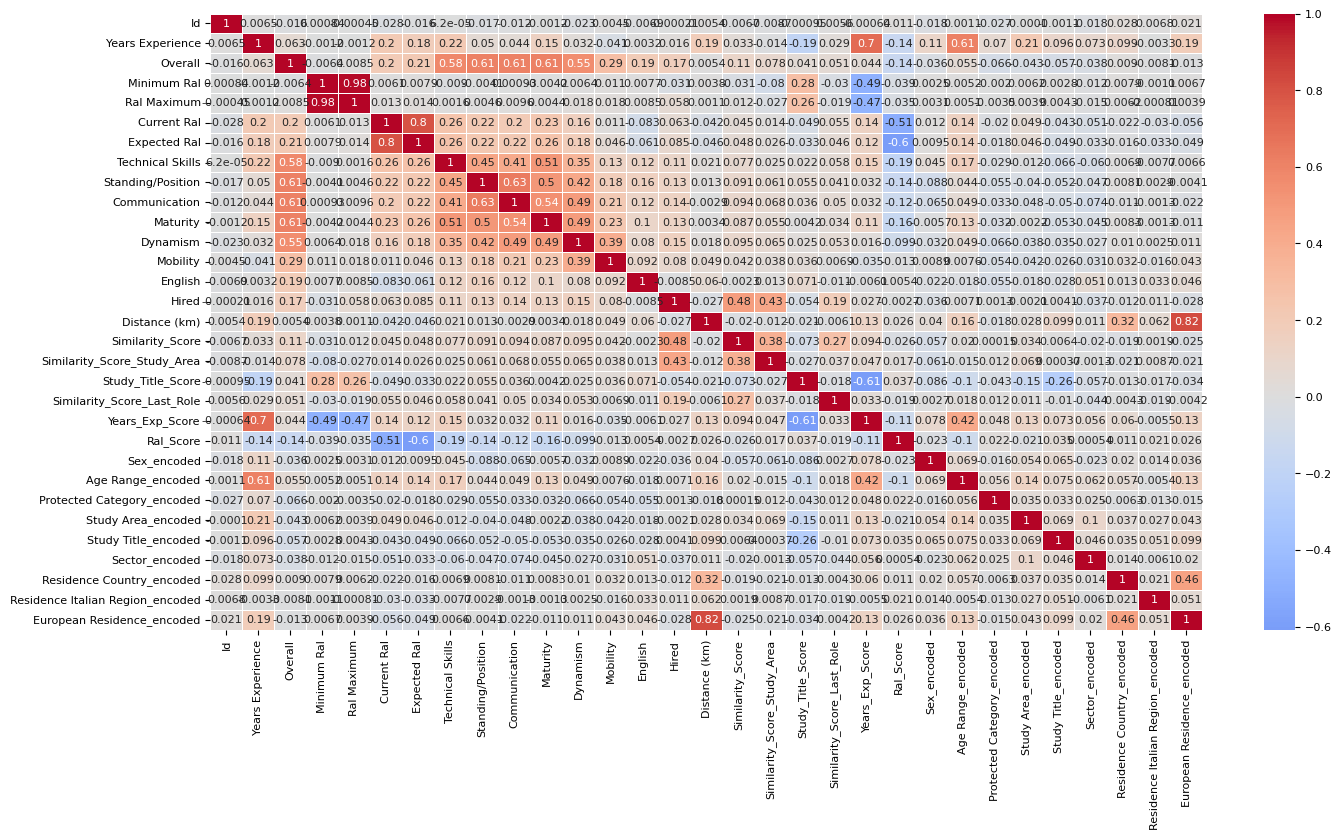

In [83]:
# Correlation matrix
corr_matrix = data_set.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.show()

##Data Analysis

###Hired

In [27]:
data_set['Hired'].value_counts()

,count
Hired,
0,9410
1,430


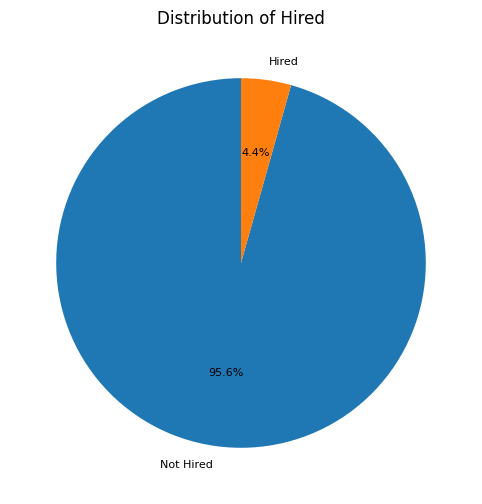

In [197]:
getPie(data_set, 'Hired', reverse_mapping)

###Sex

In [29]:
data_set['Sex_encoded'].value_counts()

,count
Sex_encoded,
1,7886
0,1954


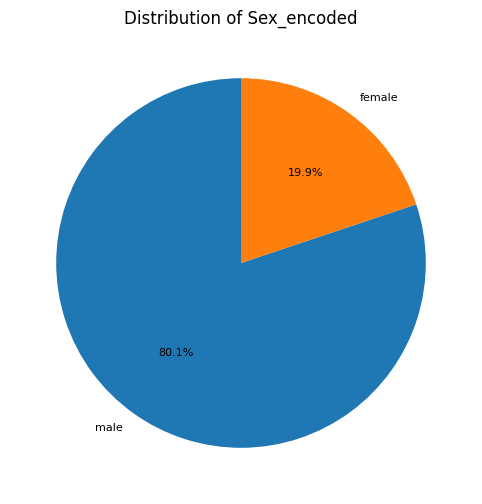

In [198]:
getPie(data_set, 'Sex_encoded', reverse_mapping)

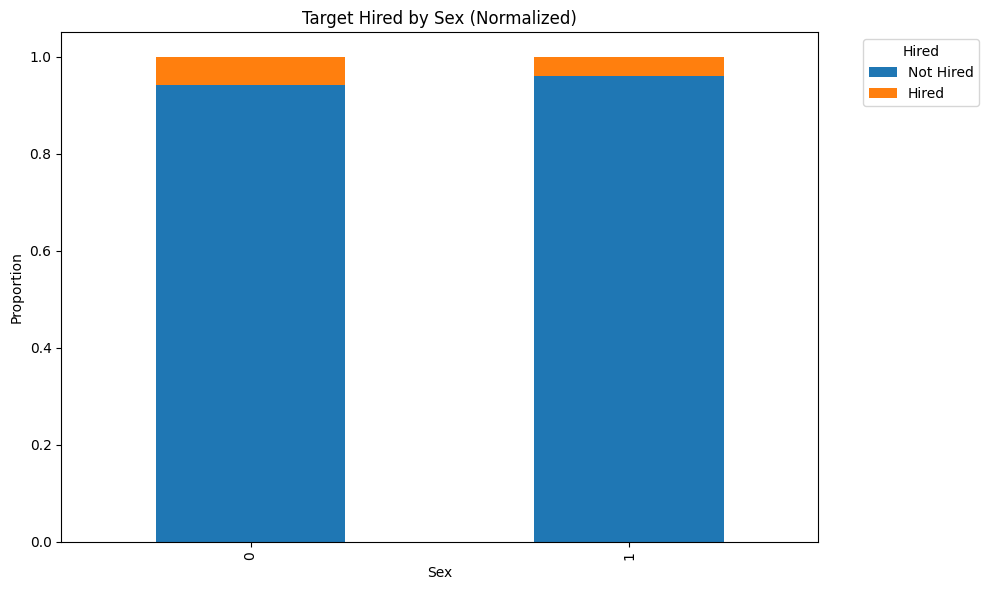

In [199]:
pivot = data_set.pivot_table(index='Sex_encoded', columns='Hired', aggfunc='size', fill_value=0)
pivot.rename(columns={0: 'Not Hired', 1: 'Hired'}, inplace=True)
pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0)

pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Target Hired by Sex (Normalized)')
plt.ylabel('Proportion')
plt.xlabel('Sex')
plt.legend(title='Hired', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

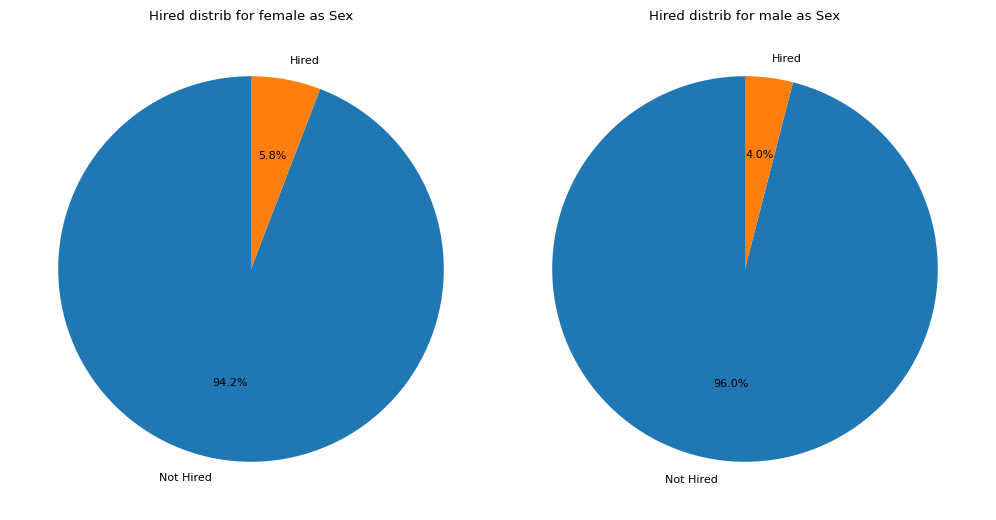

In [200]:
plot_category_distributions(data_set, 'Sex_encoded', 'Hired', encoding_mappings, reverse_mapping)

###Age Range

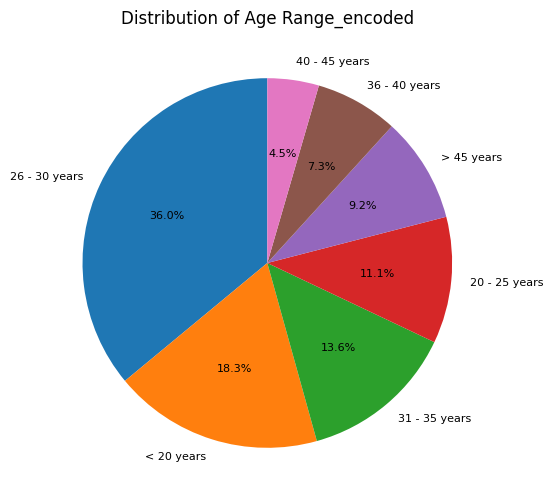

In [201]:
getPie(data_set, 'Age Range_encoded', reverse_mapping)

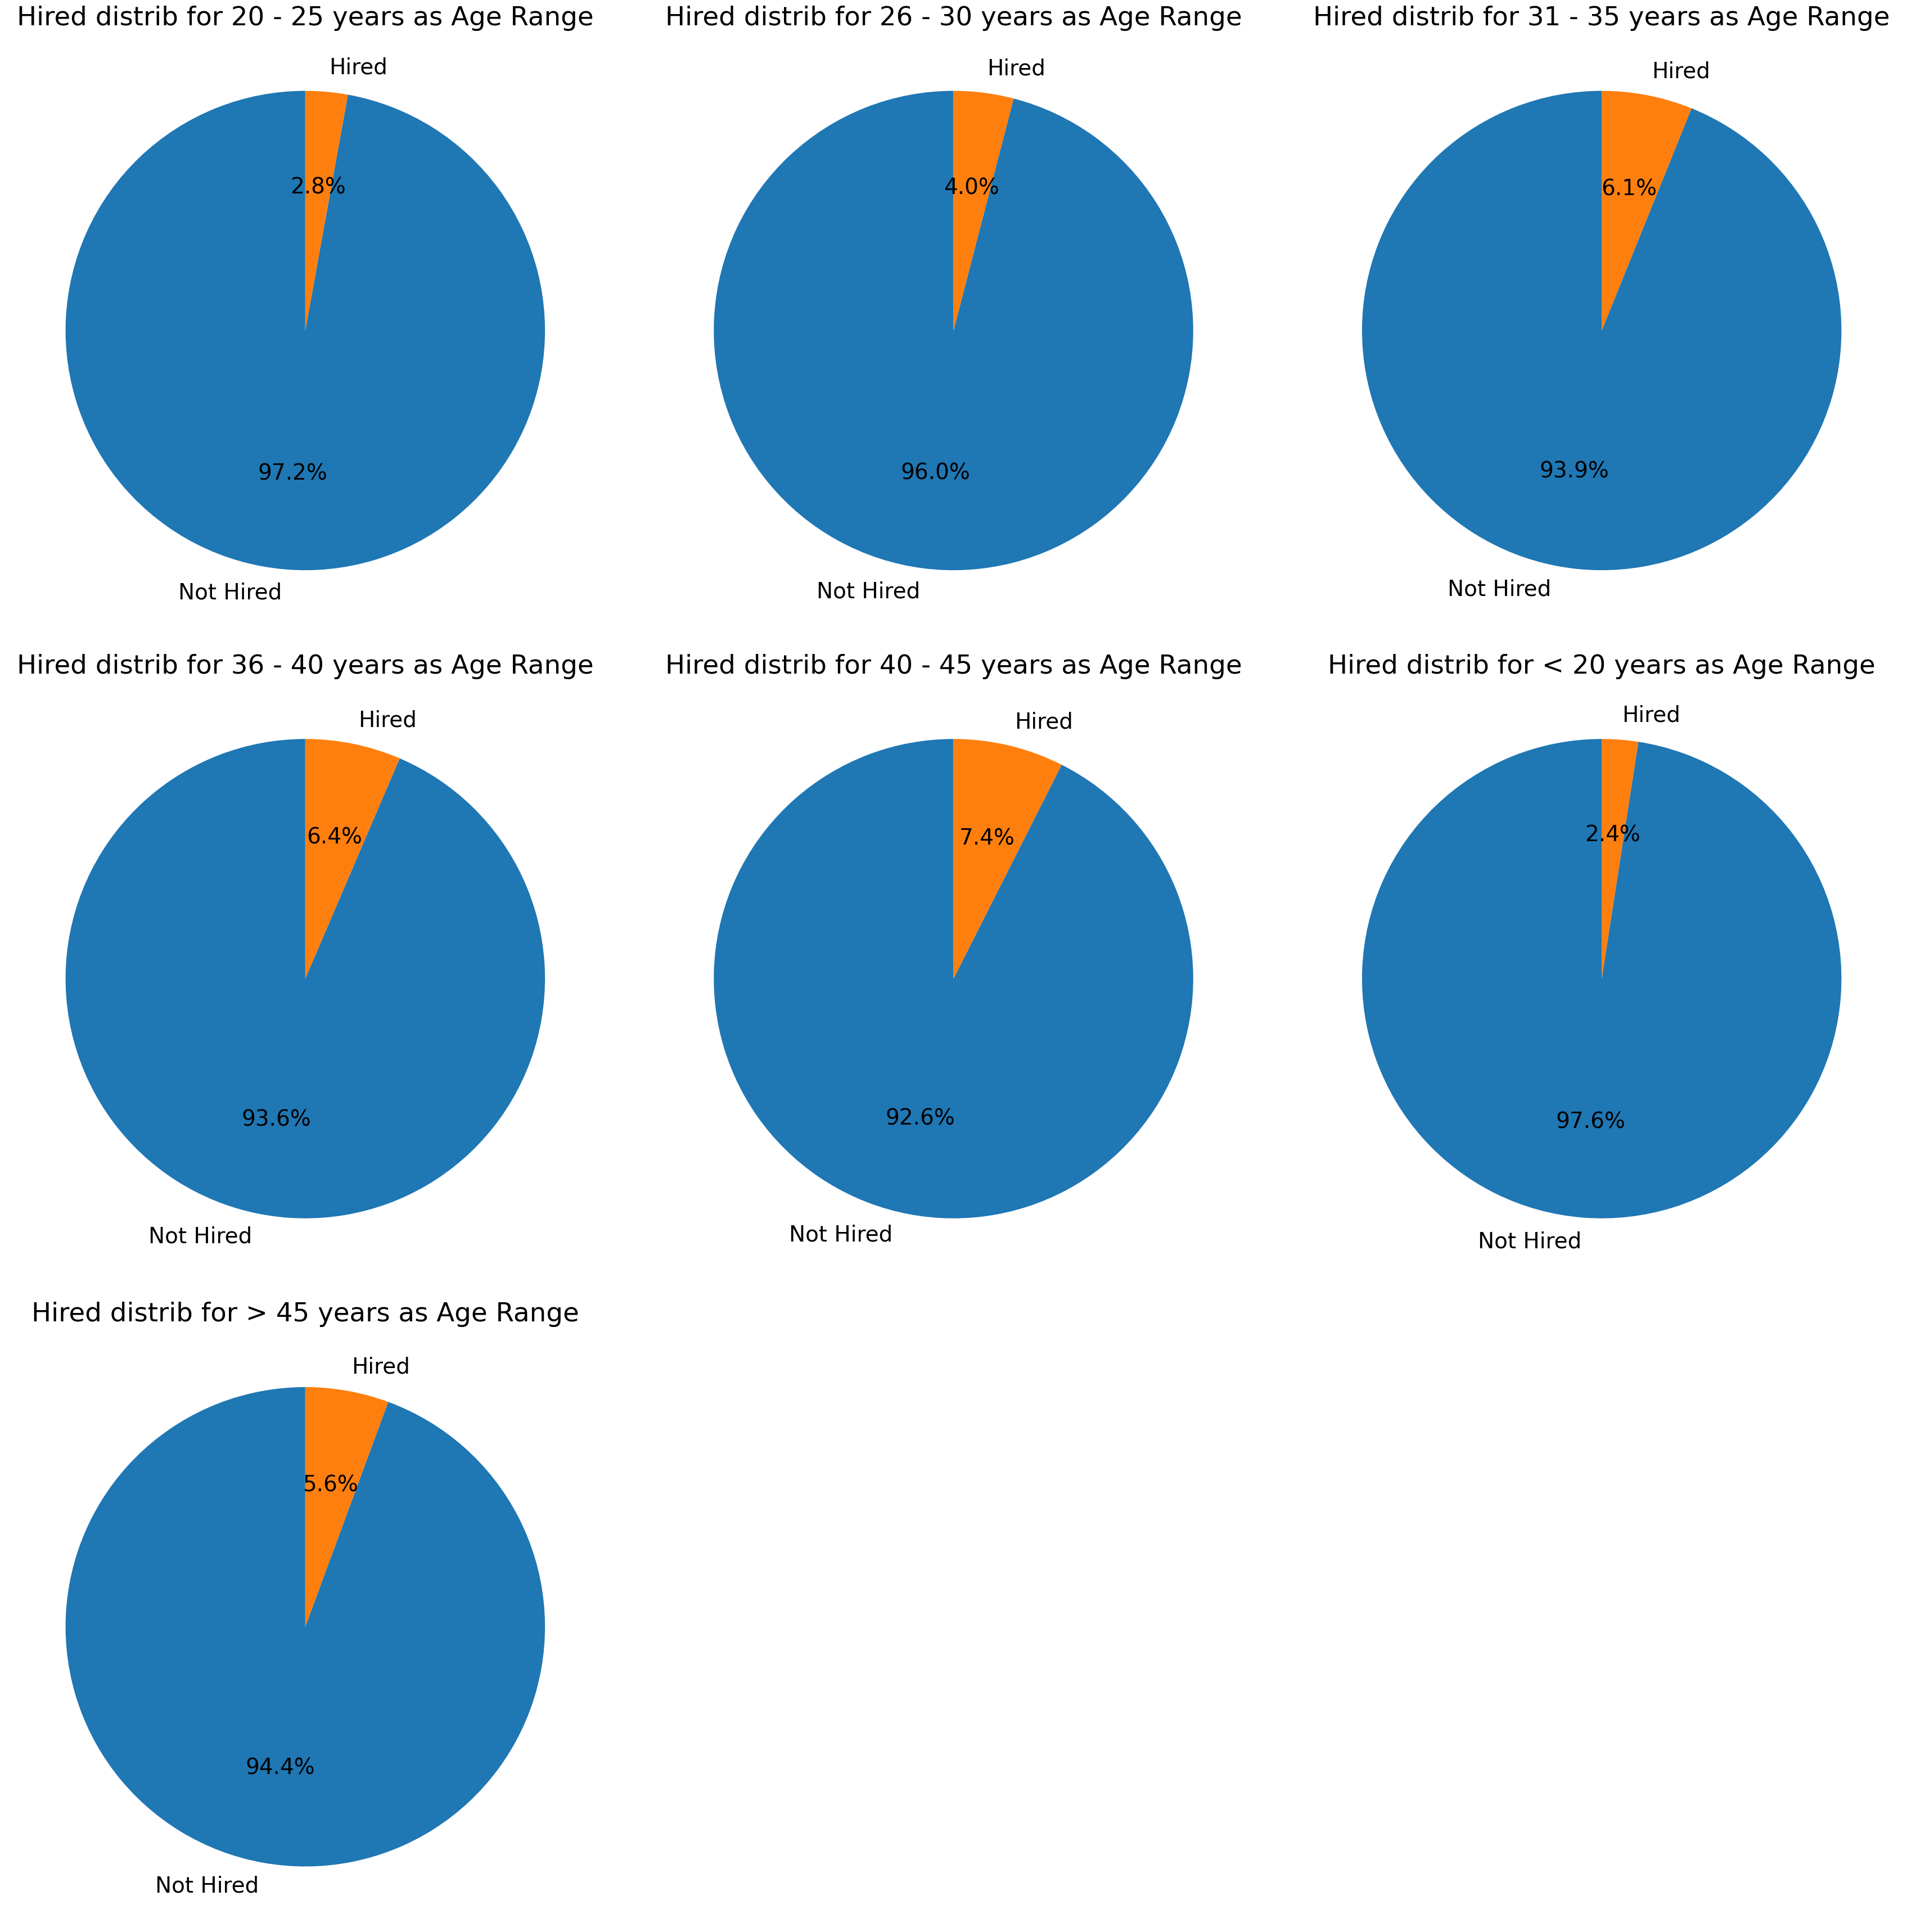

In [202]:
plot_category_distributions(data_set, 'Age Range_encoded', 'Hired', encoding_mappings, reverse_mapping)

###Protected Category

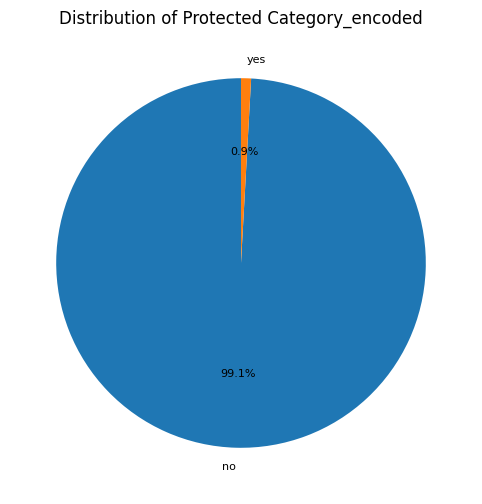

In [203]:
getPie(data_set, 'Protected Category_encoded', reverse_mapping)

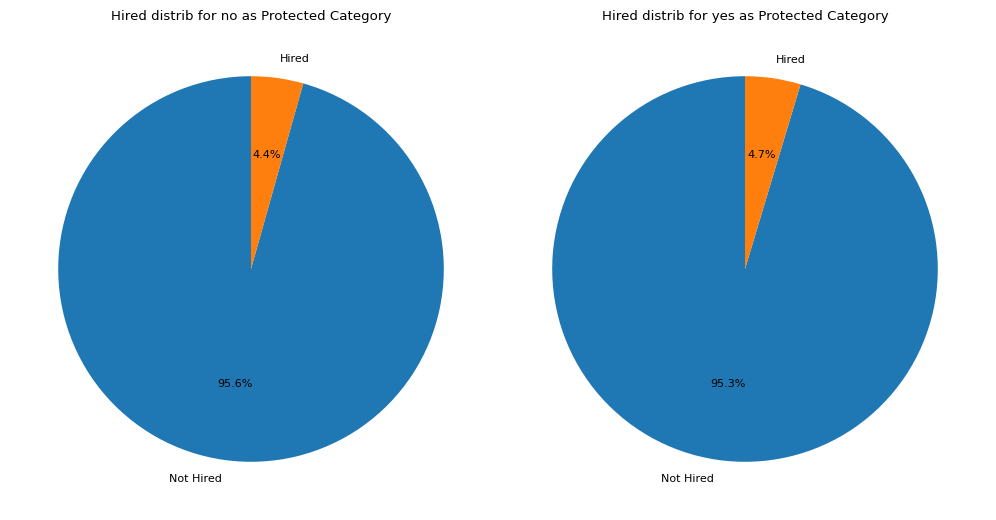

In [204]:
plot_category_distributions(data_set, 'Protected Category_encoded', 'Hired', encoding_mappings, reverse_mapping)

##Training

### Train_Test_Split
The data is first shuffled and then resampled with ADASYN to balance the 2 classes. Then it's divided in train set and data set. The `stratify` argument is used to ensure that both the dataset have the same proportion of `Protected Category` values.

In [32]:
data_set = shuffle(data_set, random_state = random_seed)
Original_ids = data_set['Id']
X = data_set.drop(columns=['Hired', 'Id'])
y = data_set['Hired']

X_res, y_res = ADASYN().fit_resample(X, y)

data_set_res = pd.concat([X_res, y_res], axis=1)
data_set_res['Id'] = Original_ids

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=data_set_res[['Protected Category_encoded', 'Hired']])


###GRIDSEARCH

In [23]:
model_list = ['dt' # decision tree
             ,'nb' # gaussian naive bayes
             ,'rf'   # random forest
             ,'lp'   # linear perceptron
             #,'svc'  # support vector
             ,'knn'  # k nearest neighbours
             ,'adb'  # adaboost
             #,'xgb' #XGBoost
             ,'lr' #Linear Regression
            ]

model_params = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-12,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state),
           'param': [{'kernel': ['rbf'],
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],
                    },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[20,30,40,50]
                     ,'learning_rate':[0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{
                      'max_depth': [*range(4,30,4)],
                      'n_estimators':[*range(10,30,5)],
                      'class_weight': [None,'balanced']
                      }]
          },
    'xgb': {'name': 'XGBoost             ',
           'estimator': XGBClassifier(random_state=random_state),
           'param': [{
                      'max_depth': [*range(4,30,4)],
                      'n_estimators':[*range(10,30,5)]
                      }]
          },
    'lr': {'name': 'Linear Regression   ',
           'estimator': LinearRegression(),
           'param': [{'fit_intercept': [True, False]}]
          }

}


In [24]:
scorings = ['accuracy'
            ,'precision_macro'
            ,'recall_macro'
            ,'f1_macro'
            ]

In [26]:
from sklearn.model_selection import ParameterGrid
trials = {m: len(list(ParameterGrid(model_params[m]['param']))) for m in model_list}
trials

{'dt': 38, 'nb': 9, 'rf': 56, 'lp': 4, 'knn': 6, 'adb': 20, 'lr': 2}

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
clfs = []
predictions = {}

for scoring in scorings:
    for m in model_list:
        print(f"Training model: {model_params[m]['name']} with scoring: {scoring}")

        clf = GridSearchCV(
            model_params[m]['estimator'],
            model_params[m]['param'],
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )

        clf.fit(X_train, y_train)
        y_true, y_pred = y_test, clf.predict(X_test)
        if m == 'lr':
          y_pred = (y_pred > 0.5).astype(int)

        if m not in predictions:
            predictions[m] = {}
        predictions[m][scoring] = y_pred
        cr = classification_report(y_true, y_pred, output_dict=True, zero_division=1)

        results.append({
            'scoring': scoring,
            'model': model_params[m]['name'],
            'best_params': clf.best_params_,
            'accuracy': cr['accuracy'],
            'precision': cr['macro avg']['precision'],
            'recall': cr['macro avg']['recall'],
            'f1_score': cr['macro avg']['f1-score']
            #,'roc_auc': cr['macro avg']['roc_auc']
        })

        clfs.append(clf)

results_df = pd.DataFrame(results)


Training model: Decision Tree        with scoring: accuracy
Training model: Gaussian Naive Bayes with scoring: accuracy
Training model: Random forest        with scoring: accuracy
Training model: Linear Perceptron    with scoring: accuracy
Training model: K Nearest Neighbor  with scoring: accuracy
Training model: AdaBoost            with scoring: accuracy
Training model: Linear Regression    with scoring: accuracy


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Training model: Decision Tree        with scoring: precision_macro
Training model: Gaussian Naive Bayes with scoring: precision_macro
Training model: Random forest        with scoring: precision_macro
Training model: Linear Perceptron    with scoring: precision_macro
Training model: K Nearest Neighbor  with scoring: precision_macro
Training model: AdaBoost            with scoring: precision_macro
Training model: Linear Regression    with scoring: precision_macro


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Training model: Decision Tree        with scoring: recall_macro
Training model: Gaussian Naive Bayes with scoring: recall_macro
Training model: Random forest        with scoring: recall_macro
Training model: Linear Perceptron    with scoring: recall_macro
Training model: K Nearest Neighbor  with scoring: recall_macro
Training model: AdaBoost            with scoring: recall_macro
Training model: Linear Regression    with scoring: recall_macro


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Training model: Decision Tree        with scoring: f1_macro
Training model: Gaussian Naive Bayes with scoring: f1_macro
Training model: Random forest        with scoring: f1_macro
Training model: Linear Perceptron    with scoring: f1_macro
Training model: K Nearest Neighbor  with scoring: f1_macro
Training model: AdaBoost            with scoring: f1_macro
Training model: Linear Regression    with scoring: f1_macro


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


In [29]:
for score in scorings:
    scoring_filter = score
    display(results_df[results_df.scoring==scoring_filter]\
                .sort_values(by='f1_score',ascending=False)\
                .drop('scoring',axis=1)\
                .style.format(precision=3)\
                .set_caption('\nResults for scoring "{}"'.format(scoring_filter)))

,model,best_params,accuracy,precision,recall,f1_score
2,Random forest,"{'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 25}",0.995,0.995,0.995,0.995
0,Decision Tree,"{'class_weight': None, 'max_depth': 16}",0.993,0.993,0.993,0.993
5,AdaBoost,"{'learning_rate': 1.5, 'n_estimators': 50}",0.988,0.988,0.988,0.988
4,K Nearest Neighbor,{'n_neighbors': 1},0.949,0.950,0.949,0.949
6,Linear Regression,{'fit_intercept': True},0.878,0.885,0.878,0.878
3,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping': False}",0.833,0.868,0.832,0.828
1,Gaussian Naive Bayes,{'var_smoothing': 1e-08},0.760,0.812,0.761,0.750


,model,best_params,accuracy,precision,recall,f1_score
9,Random forest,"{'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 25}",0.995,0.995,0.995,0.995
7,Decision Tree,"{'class_weight': None, 'max_depth': 16}",0.993,0.993,0.993,0.993
12,AdaBoost,"{'learning_rate': 1.5, 'n_estimators': 50}",0.988,0.988,0.988,0.988
11,K Nearest Neighbor,{'n_neighbors': 1},0.949,0.950,0.949,0.949
13,Linear Regression,{'fit_intercept': True},0.878,0.885,0.878,0.878
10,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping': False}",0.833,0.868,0.832,0.828
8,Gaussian Naive Bayes,{'var_smoothing': 1e-08},0.760,0.812,0.761,0.750


,model,best_params,accuracy,precision,recall,f1_score
16,Random forest,"{'class_weight': 'balanced', 'max_depth': 28, 'n_estimators': 25}",0.995,0.995,0.995,0.995
14,Decision Tree,"{'class_weight': None, 'max_depth': 16}",0.993,0.993,0.993,0.993
19,AdaBoost,"{'learning_rate': 1.5, 'n_estimators': 50}",0.988,0.988,0.988,0.988
18,K Nearest Neighbor,{'n_neighbors': 1},0.949,0.950,0.949,0.949
20,Linear Regression,{'fit_intercept': True},0.878,0.885,0.878,0.878
17,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping': False}",0.833,0.868,0.832,0.828
15,Gaussian Naive Bayes,{'var_smoothing': 1e-08},0.760,0.812,0.761,0.750


,model,best_params,accuracy,precision,recall,f1_score
23,Random forest,"{'class_weight': 'balanced', 'max_depth': 28, 'n_estimators': 25}",0.995,0.995,0.995,0.995
21,Decision Tree,"{'class_weight': None, 'max_depth': 16}",0.993,0.993,0.993,0.993
26,AdaBoost,"{'learning_rate': 1.5, 'n_estimators': 50}",0.988,0.988,0.988,0.988
25,K Nearest Neighbor,{'n_neighbors': 1},0.949,0.950,0.949,0.949
27,Linear Regression,{'fit_intercept': True},0.878,0.885,0.878,0.878
24,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping': False}",0.833,0.868,0.832,0.828
22,Gaussian Naive Bayes,{'var_smoothing': 1e-08},0.760,0.812,0.761,0.750


In [43]:
model = CustomKerasClassifier(input_shape=(X_train.shape[1],))

param_grid = {
    'neurons': [128],
    'activation': ['relu'],
    'optimizer': ['adam'],
    'batch_size': [16, 32, 64],
    'epochs': [10, 15, 20]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(f"Best params: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")


Epoch 1/20
938/938 [==============================] - 9s 5ms/step - loss: 0.4160 - accuracy: 0.8018
Epoch 2/20
938/938 [==============================] - 5s 5ms/step - loss: 0.2474 - accuracy: 0.8996
Epoch 3/20
938/938 [==============================] - 7s 8ms/step - loss: 0.2082 - accuracy: 0.9150
Epoch 4/20
938/938 [==============================] - 6s 6ms/step - loss: 0.1890 - accuracy: 0.9280
Epoch 5/20
938/938 [==============================] - 5s 5ms/step - loss: 0.1866 - accuracy: 0.9278
Epoch 6/20
938/938 [==============================] - 8s 8ms/step - loss: 0.1586 - accuracy: 0.9366
Epoch 7/20
938/938 [==============================] - 6s 6ms/step - loss: 0.1496 - accuracy: 0.9453
Epoch 8/20
938/938 [==============================] - 5s 5ms/step - loss: 0.1440 - accuracy: 0.9482
Epoch 9/20
938/938 [==============================] - 7s 7ms/step - loss: 0.1328 - accuracy: 0.9523
Epoch 10/20
938/938 [==============================] - 6s 6ms/step - loss: 0.1210 - accuracy: 0.9557

###Best Models

In [33]:
best_model_params = {
    'dt': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(random_state=random_state, max_depth=16, class_weight=None),
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(var_smoothing=1e-08),
          },
    'lp': {'name': 'Linear Perceptron',
           'estimator': Perceptron(random_state=random_state, class_weight='balanced', early_stopping=False),
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(n_neighbors=1),
       },
    'adb':{'name': 'AdaBoost',
           'estimator': AdaBoostClassifier(random_state=random_state, learning_rate=1.5, n_estimators=50),
          },
    'rf': {'name': 'Random forest',
           'estimator': RandomForestClassifier(random_state=random_state, class_weight='balanced', max_depth=28, n_estimators=25),
          },
    'lr': {'name': 'Linear Regression',
           'estimator': LinearRegression(fit_intercept=True),
          }
}


In [34]:
models = {best_model_params[m]['name']: best_model_params[m]['estimator'] for m in best_model_params.keys()}

In [35]:
metrics = []
predictions = {}

for name, model in models.items():
    fit_predict_model(name, model, X_train, y_train, X_test, y_test, metrics, predictions)

metrics = pd.DataFrame(metrics)


Fitting Decision Tree...
Fitting Gaussian Naive Bayes...
Fitting Linear Perceptron...
Fitting K Nearest Neighbor...
Fitting AdaBoost...
Fitting Random forest...
Fitting Linear Regression...


In [36]:
metrics

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Decision Tree,0.993,0.993,0.992,0.993,0.993
1,Gaussian Naive Bayes,0.797,0.724,0.958,0.825,0.926
2,Linear Perceptron,0.897,0.936,0.851,0.892,0.897
3,K Nearest Neighbor,0.950,0.924,0.980,0.951,0.950
4,AdaBoost,0.987,0.987,0.987,0.987,0.999
5,Random forest,0.994,0.994,0.995,0.994,1.000
6,Linear Regression,0.879,0.935,0.813,0.870,0.964


####Neural Networks

In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [45]:
neural_models = []
neural_predictions = []
histories = []
epochs = 20
batch_size = 16
i = 0
for seed in range(85, 88):
#for seed in range(85, 92):
    name = f'Neural Network {i+1}'
    i+=1
    fit_predict_nn(name, seed, neural_models, histories, X_train, y_train, X_test, neural_predictions, early_stopping, epochs, batch_size)

Fitting model Neural Network 1...
Epoch 1/20
751/751 [==============================] - 17s 16ms/step - loss: 0.4291 - accuracy: 0.7936 - val_loss: 0.4548 - val_accuracy: 0.7747
Epoch 2/20
751/751 [==============================] - 12s 16ms/step - loss: 0.2564 - accuracy: 0.8974 - val_loss: 0.2158 - val_accuracy: 0.9070
Epoch 3/20
751/751 [==============================] - 8s 11ms/step - loss: 0.2183 - accuracy: 0.9129 - val_loss: 0.2700 - val_accuracy: 0.8827
Epoch 4/20
751/751 [==============================] - 5s 7ms/step - loss: 0.1934 - accuracy: 0.9232 - val_loss: 0.2105 - val_accuracy: 0.9134
Epoch 5/20
751/751 [==============================] - 6s 9ms/step - loss: 0.1754 - accuracy: 0.9312 - val_loss: 0.1227 - val_accuracy: 0.9580
Epoch 6/20
751/751 [==============================] - 5s 6ms/step - loss: 0.1581 - accuracy: 0.9427 - val_loss: 0.1413 - val_accuracy: 0.9464
Epoch 7/20
751/751 [==============================] - 5s 7ms/step - loss: 0.1490 - accuracy: 0.9446 - val_los

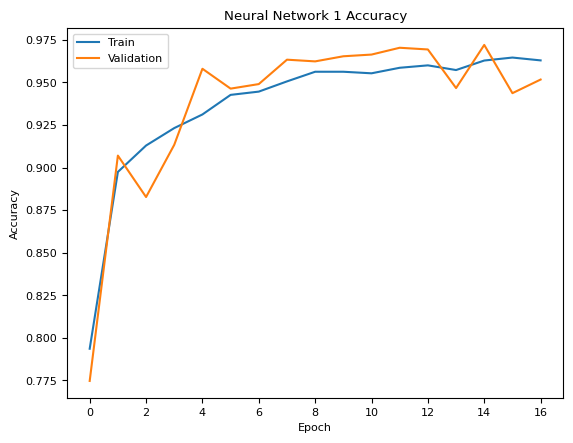

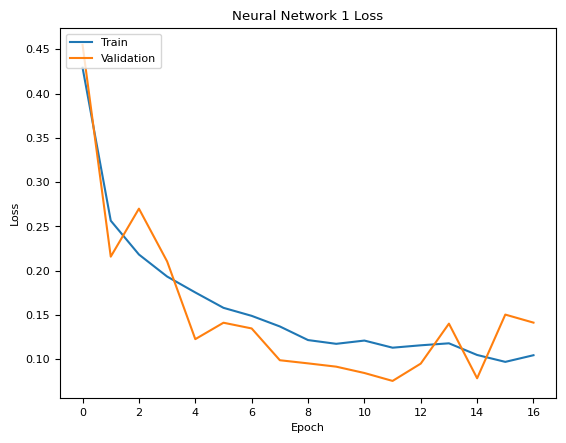

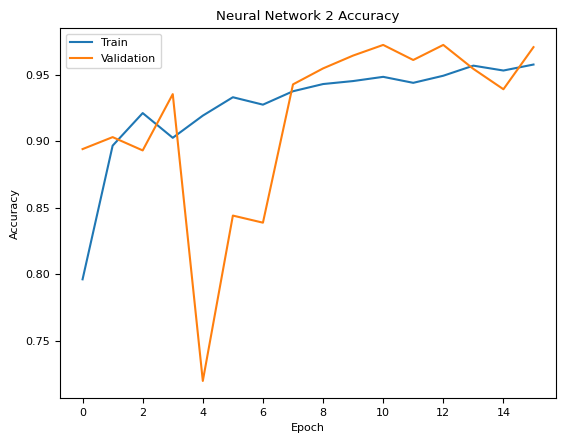

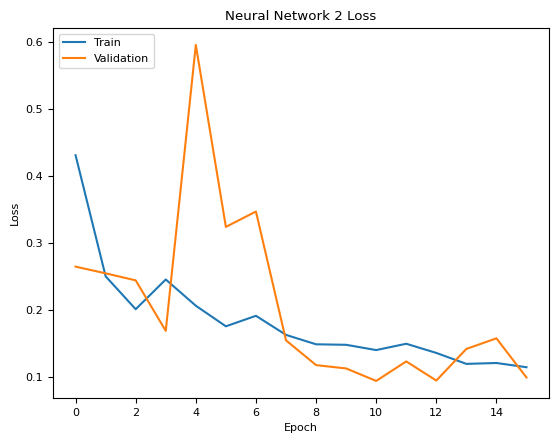

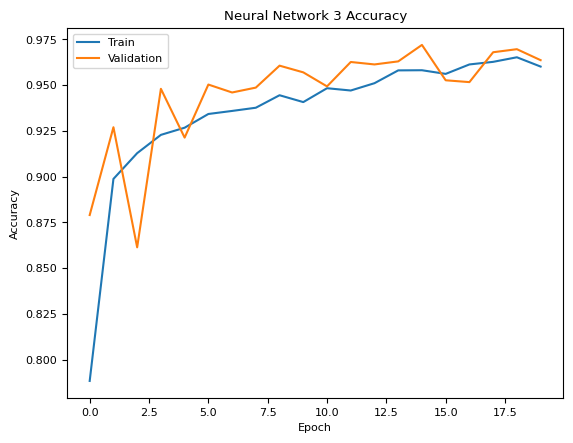

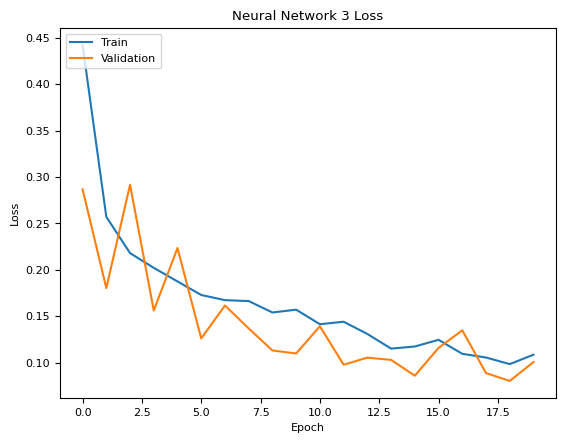

In [48]:
for i, h in enumerate(histories):
  name = f"Neural Network {i+1}"
  plot_val_train(h, name)

### NN export

In [216]:
for i, model in enumerate(neural_models):
  model.save(f'saved_NNs/neural_network_model{i}')

###NN import

In [47]:
from tensorflow.keras.models import load_model
neural_models = []

for i in range(0,3):
  source_path = f'saved_models/content/saved_NNs/neural_network_model{i}'
  model = load_model(source_path)
  neural_models.append(model)


###NN predictions

In [48]:
i = 0
neural_predictions = []
for nn in neural_models:
  name = f"Neural Network {i}"
  predict_nn(name, nn, X_test, neural_predictions)
  i+=1

Predicting with model Neural Network 0...
118/118 [==============================] - 1s 3ms/step
Predictions from model Neural Network 0 stored.


Predicting with model Neural Network 1...
118/118 [==============================] - 1s 4ms/step
Predictions from model Neural Network 1 stored.


Predicting with model Neural Network 2...
118/118 [==============================] - 1s 3ms/step
Predictions from model Neural Network 2 stored.




In [49]:
nn_metrics = []

for i, y_pred in enumerate(neural_predictions):
  name = f"Neural Network {i+1}"
  calc_nn_metrics(y_pred, y_test, nn_metrics, name)

nn_metrics = pd.DataFrame(nn_metrics)
nn_metrics

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Neural Network 1,0.972,0.964,0.980,0.972,0.972
1,Neural Network 2,0.970,0.967,0.974,0.970,0.970
2,Neural Network 3,0.965,0.952,0.979,0.965,0.965


###Performance

In [50]:
combined_metrics = pd.concat([metrics, nn_metrics], ignore_index=True)
combined_metrics

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Decision Tree,0.993,0.993,0.992,0.993,0.993
1,Gaussian Naive Bayes,0.797,0.724,0.958,0.825,0.926
2,Linear Perceptron,0.897,0.936,0.851,0.892,0.897
3,K Nearest Neighbor,0.950,0.924,0.980,0.951,0.950
4,AdaBoost,0.987,0.987,0.987,0.987,0.999
5,Random forest,0.994,0.994,0.995,0.994,1.000
6,Linear Regression,0.879,0.935,0.813,0.870,0.964
7,Neural Network 1,0.972,0.964,0.980,0.972,0.972
8,Neural Network 2,0.970,0.967,0.974,0.970,0.970
9,Neural Network 3,0.965,0.952,0.979,0.965,0.965


In [51]:
for i,model in enumerate(neural_models):
  models[f"Neural Network {i+1}"] = model

for i, prediction_list in enumerate(neural_predictions):
  predictions[f"Neural Network {i+1}"] = prediction_list.flatten()

##Bias detection

In [60]:
# Columns groups of interest
sensitive_features = ['Sex_encoded', 'Age Range_encoded', 'European Residence_encoded', 'Protected Category_encoded']
non_sensitive_features = data_set.columns.difference(sensitive_features)

models_list = [model for model in models]

# Tresholds
tolerance = 0.15
significance_level = 0.1

###Demographic Parity

In [61]:
index = list(models.keys())
getFairnessTab(calculate_demographic_parity,
               models,
               sensitive_features,
               predictions,
               index,
               X_test,
               significance_level,
               tolerance,
               False)

,Sex_encoded,Age Range_encoded,European Residence_encoded,Protected Category_encoded
Decision Tree,male,< 20 years,non-european,yes
Gaussian Naive Bayes,male,> 45 years,non-european,yes
Linear Perceptron,male,< 20 years,non-european,yes
K Nearest Neighbor,male,< 20 years,non-european,yes
AdaBoost,male,< 20 years,non-european,yes
Random forest,male,< 20 years,non-european,yes
Linear Regression,male,< 20 years,non-european,yes
Neural Network 1,male,< 20 years,non-european,yes
Neural Network 2,male,< 20 years,non-european,yes
Neural Network 3,male,< 20 years,non-european,yes


### Equalized Odds

In [62]:
index = list(models.keys())
getFairnessTab(calculate_equalized_odds,
               models,
               sensitive_features,
               predictions,
               index,
               X_test,
               significance_level,
               tolerance,
               False)

,Sex_encoded,Age Range_encoded,European Residence_encoded,Protected Category_encoded
Decision Tree,,,non-european,
Gaussian Naive Bayes,male,,non-european,yes
Linear Perceptron,,,non-european,yes
K Nearest Neighbor,,,non-european,yes
AdaBoost,,,,yes
Random forest,,,,yes
Linear Regression,,,non-european,yes
Neural Network 1,,,non-european,yes
Neural Network 2,,,non-european,yes
Neural Network 3,,,non-european,yes


##Explainers

###LIME (Local Interpretable Model-agnostic Explanations)
explanations for samples with index = 16,17,18, with the top 5 most relevant features.

LIME EXPLANATIONS FOR Decision Tree


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Figure size 500x300 with 0 Axes>

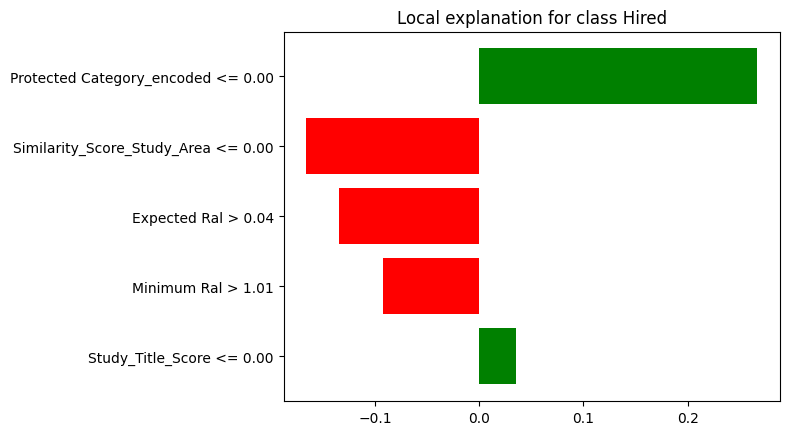

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


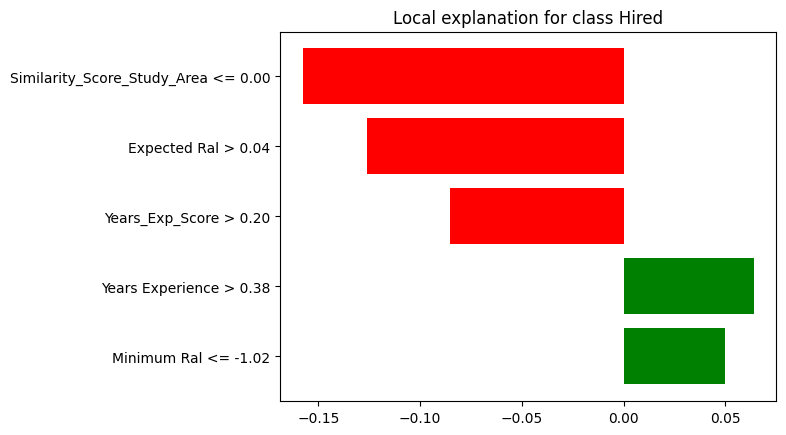

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


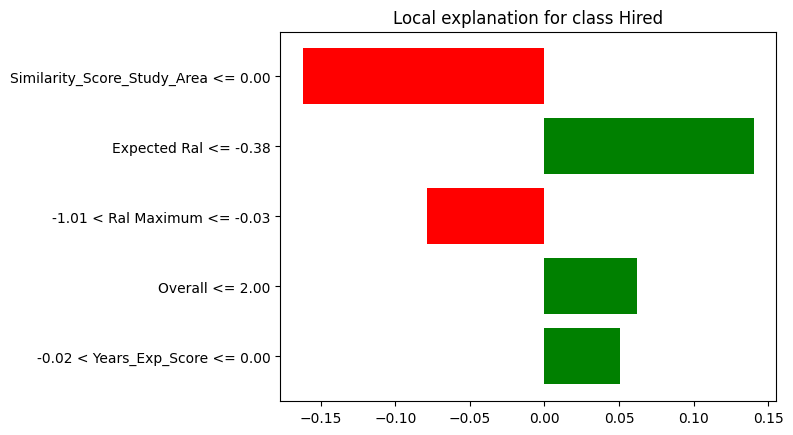

LIME EXPLANATIONS FOR Gaussian Naive Bayes


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


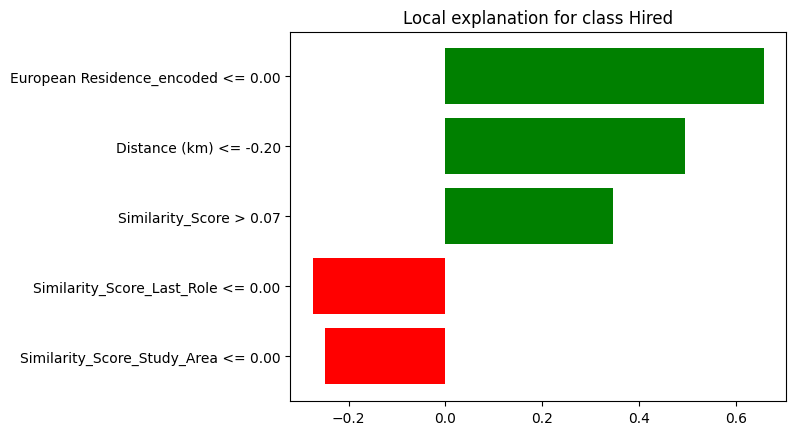

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


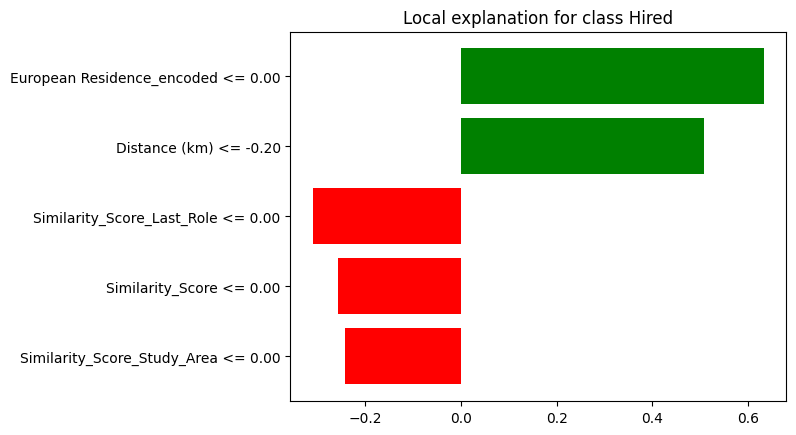

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


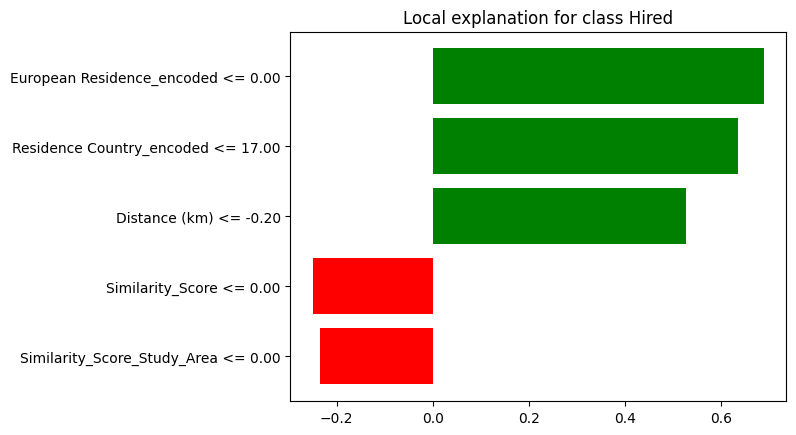

LIME EXPLANATIONS FOR K Nearest Neighbor


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


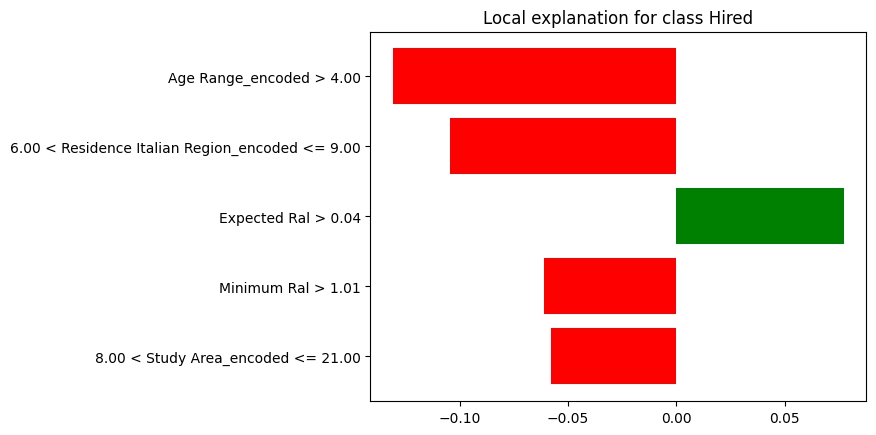

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


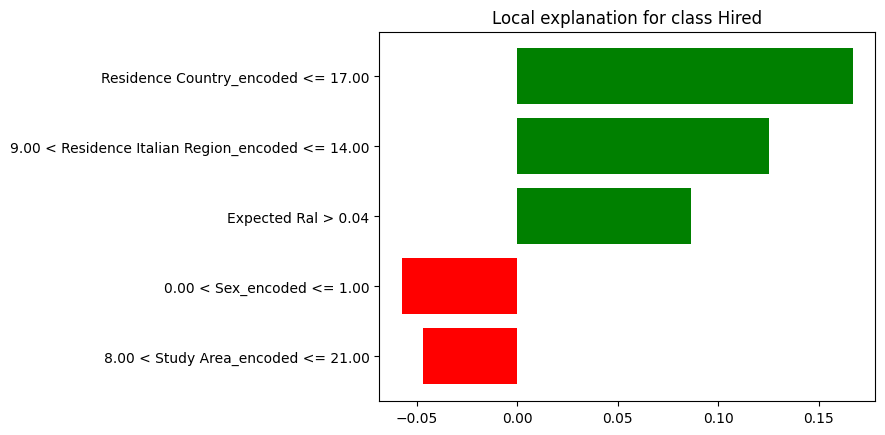

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


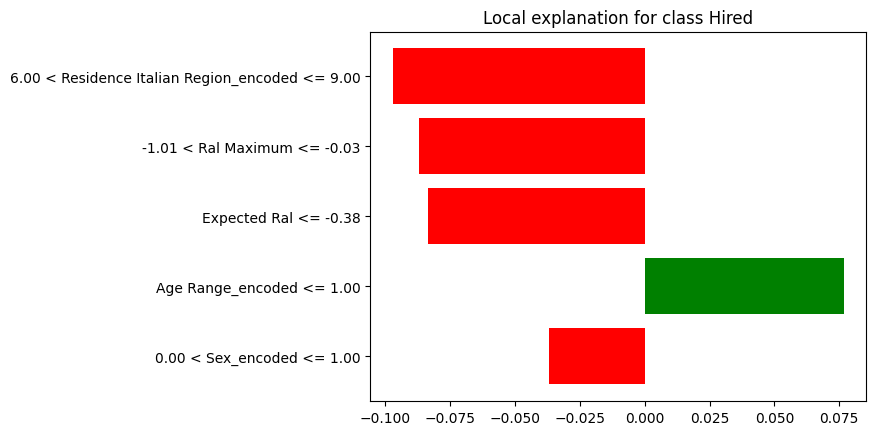

LIME EXPLANATIONS FOR AdaBoost


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


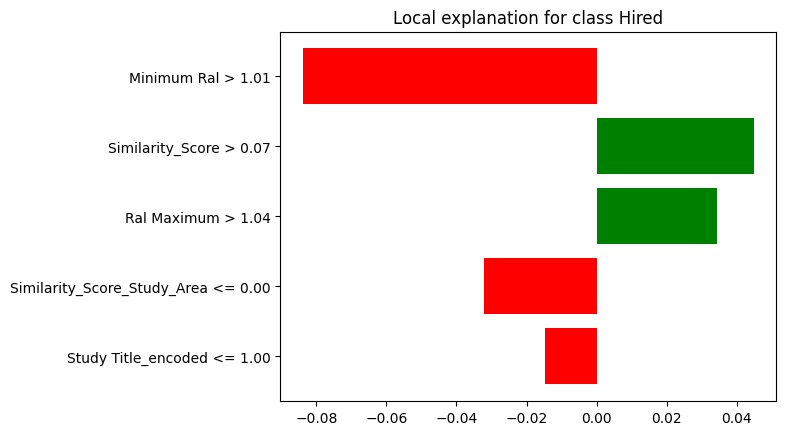

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


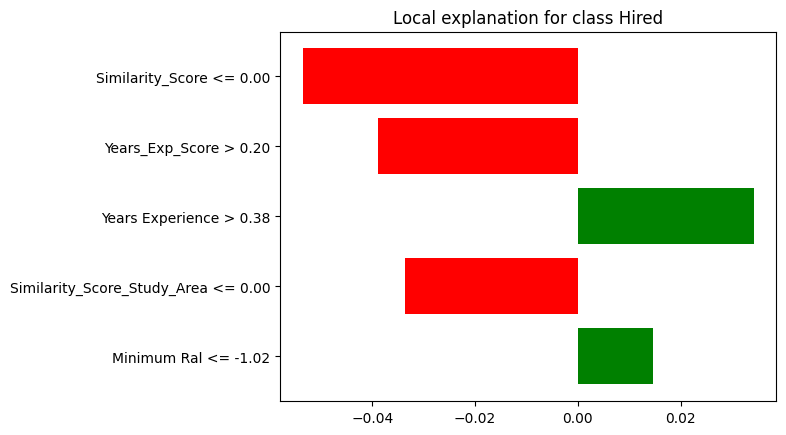

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


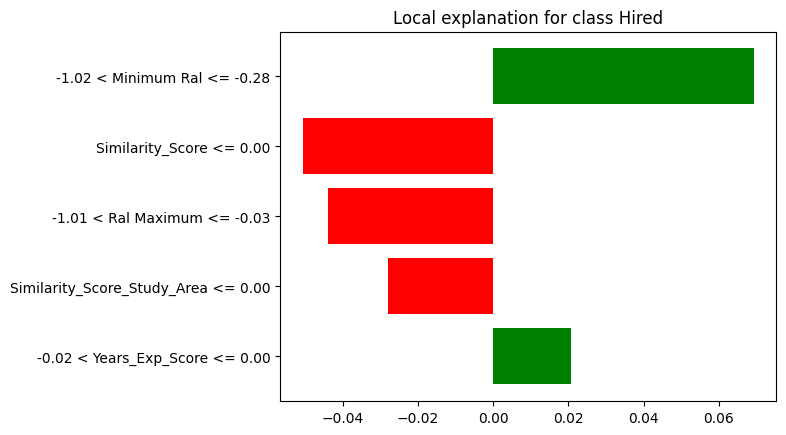

LIME EXPLANATIONS FOR Random forest


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


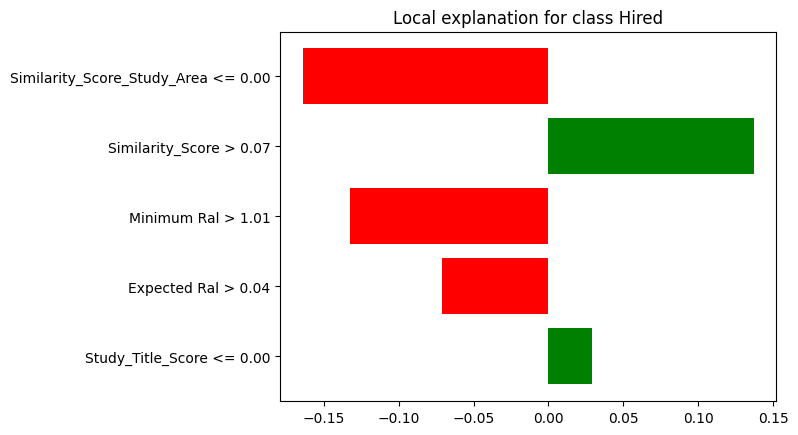

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


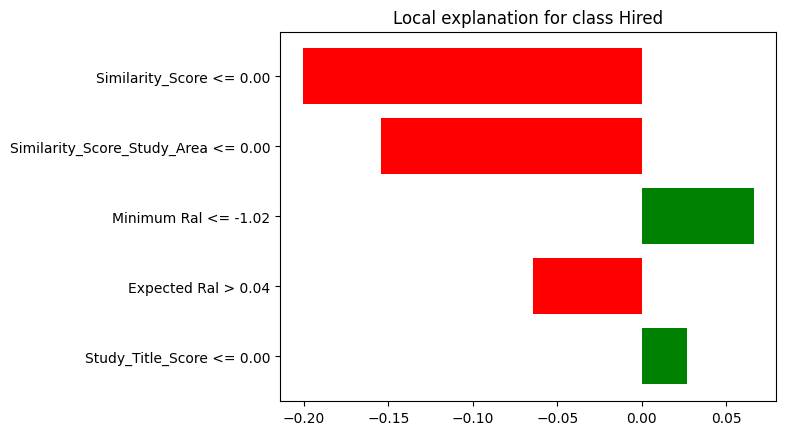

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


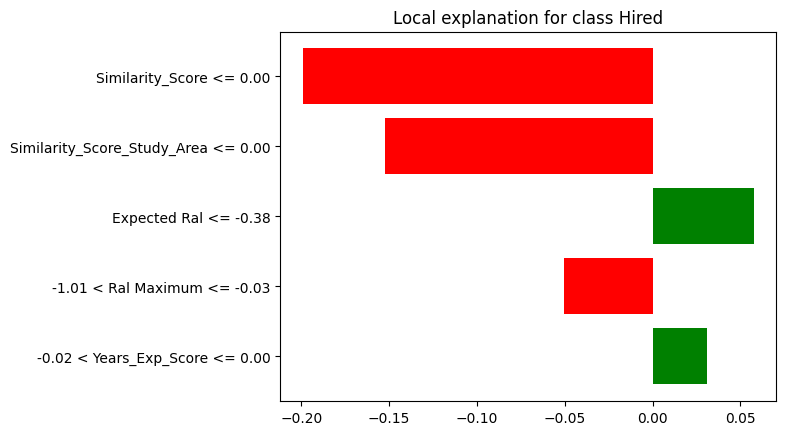

In [79]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode="classification",
    feature_names=X_train.columns.tolist(),
    class_names=['Not Hired', 'Hired'])
plt.figure(figsize=(5, 3))

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        print(f"LIME EXPLANATIONS FOR {model_name}")
        for i in range(16,19):
            exp_dt = explainer.explain_instance(X_test.values[i], model.predict_proba, num_features=5) #Use model directly since we're iterating through values
            fig_dt = exp_dt.as_pyplot_figure()
            plt.show()

###Shap

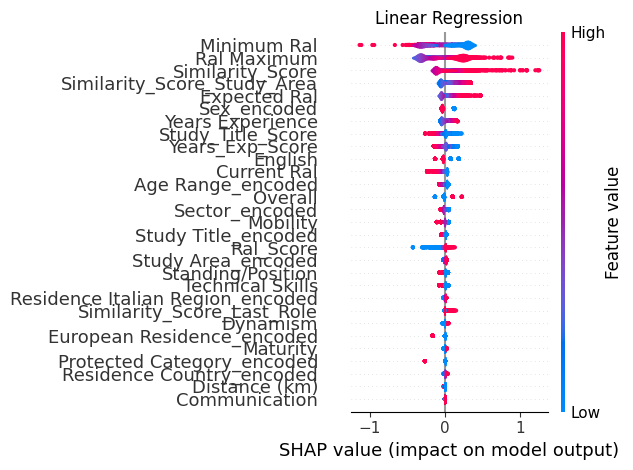

In [82]:
tot_columns = list(X_test.columns)
summaryPlot(models['Linear Regression'], X_test, tot_columns, plot_type='violin', plot_name='Linear Regression')


/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 29)


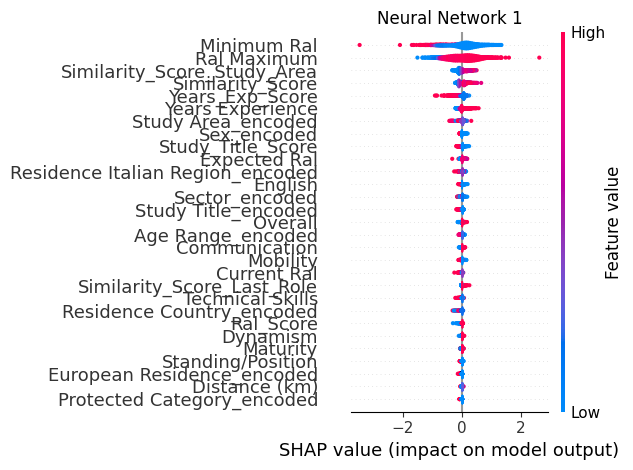

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 29)


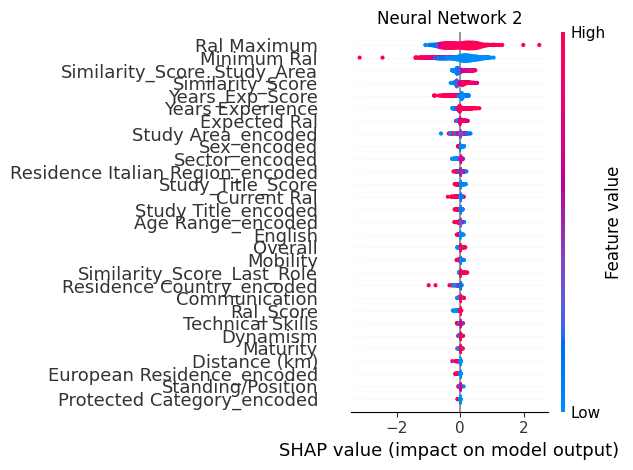

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 29)


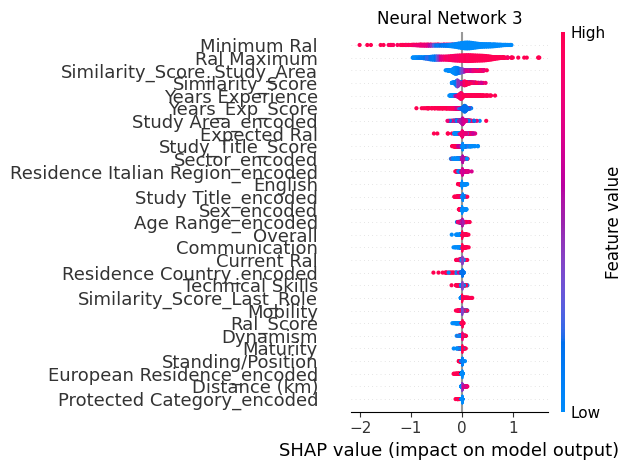

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 29)


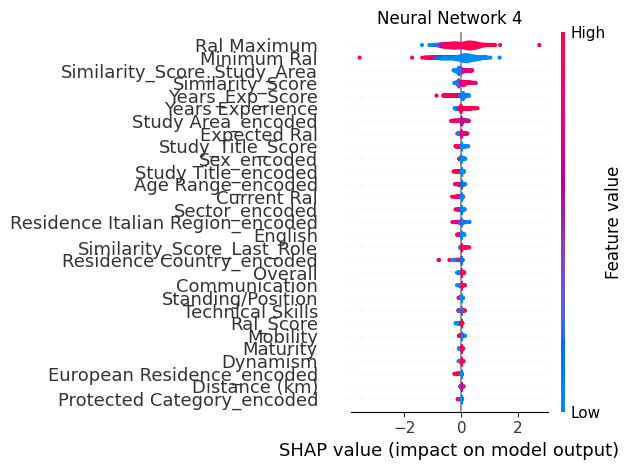

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 29)


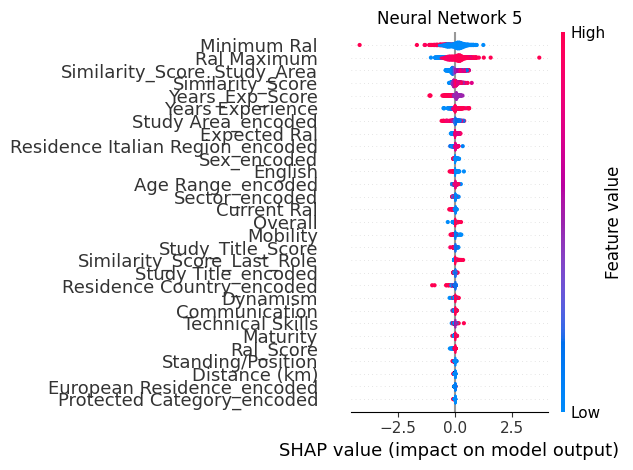

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 29)


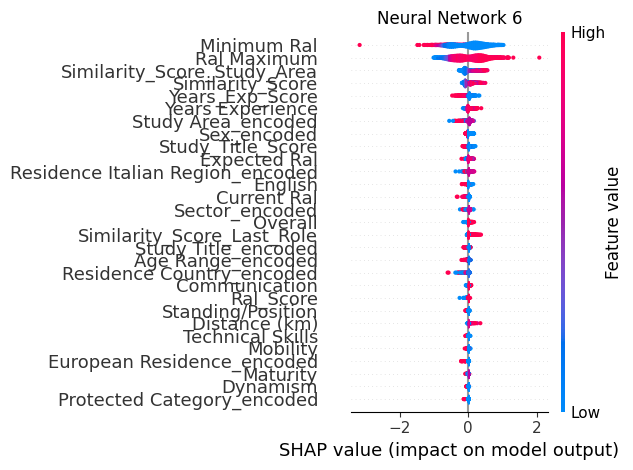

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 29)


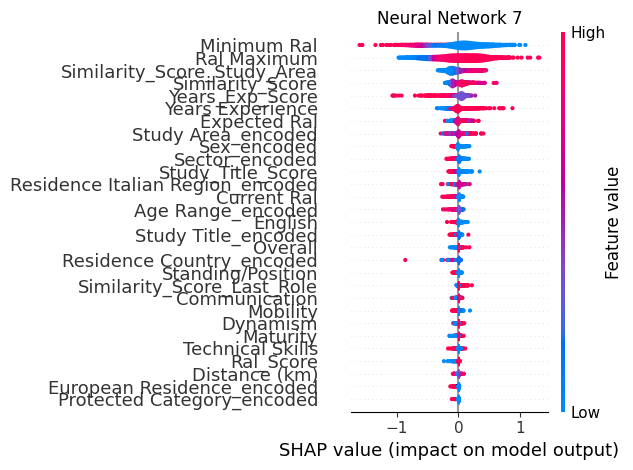

In [83]:
for i in range(1,8):
    summaryPlot(models[f"Neural Network {i}"], X_test.iloc[:1000], tot_columns, plot_type='violin', plot_name=f'Neural Network {i}')

##Fairness improvement

###Reweighing

In [63]:
X_train_reweighted, y_train_reweighted = reweight_dataset(X_train, y_train, sensitive_features)

In [64]:
print("Distribution before reweighting:")
print(X_train[sensitive_features].value_counts())

print("\n\nDistribution after reweighting:")
print(X_train_reweighted[sensitive_features].value_counts())

Distribution before reweighting:
Sex_encoded  Age Range_encoded  European Residence_encoded  Protected Category_encoded
1            1                  0                           0                             3774
0            1                  0                           0                             1829
1            5                  0                           0                             1465
             2                  0                           0                             1333
             0                  0                           0                             1126
             3                  0                           0                              934
             6                  0                           0                              852
0            2                  0                           0                              796
1            4                  0                           0                              636
0            0           

In [65]:
metrics_rew = []
predictions_rew = {}
models_rew = {best_model_params[m]['name']: best_model_params[m]['estimator'] for m in best_model_params.keys()}

for name, model in models_rew.items():
    fit_predict_model(name, model, X_train_reweighted, y_train_reweighted, X_test, y_test, metrics_rew, predictions_rew)

Fitting Decision Tree...
Fitting Gaussian Naive Bayes...
Fitting Linear Perceptron...
Fitting K Nearest Neighbor...
Fitting AdaBoost...
Fitting Random forest...
Fitting Linear Regression...


In [66]:
metrics_rew = pd.DataFrame(metrics_rew)

In [76]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [79]:
neural_models_rew = []
neural_predictions_rew = []
histories_rew = []
epochs = 20
batch_size = 16
i = 0
for seed in range(85, 88):
  name = f'Neural Network {i+1}'
  i+=1
  fit_predict_nn(name, seed, neural_models_rew, histories_rew, X_train_reweighted, y_train_reweighted, X_test, neural_predictions_rew, early_stopping, epochs, batch_size)


Fitting model Neural Network 1...
Epoch 1/20
751/751 [==============================] - 11s 7ms/step - loss: 0.3292 - accuracy: 0.8589 - val_loss: 0.4429 - val_accuracy: 0.8267
Epoch 2/20
751/751 [==============================] - 7s 9ms/step - loss: 0.1912 - accuracy: 0.9228 - val_loss: 0.1790 - val_accuracy: 0.9364
Epoch 3/20
751/751 [==============================] - 10s 13ms/step - loss: 0.1539 - accuracy: 0.9364 - val_loss: 0.1541 - val_accuracy: 0.9354
Epoch 4/20
751/751 [==============================] - 15s 20ms/step - loss: 0.1385 - accuracy: 0.9443 - val_loss: 0.0885 - val_accuracy: 0.9627
Epoch 5/20
751/751 [==============================] - 11s 15ms/step - loss: 0.1226 - accuracy: 0.9520 - val_loss: 0.0821 - val_accuracy: 0.9727
Epoch 6/20
751/751 [==============================] - 8s 11ms/step - loss: 0.1075 - accuracy: 0.9593 - val_loss: 0.0621 - val_accuracy: 0.9760
Epoch 7/20
751/751 [==============================] - 5s 6ms/step - loss: 0.0906 - accuracy: 0.9664 - val_

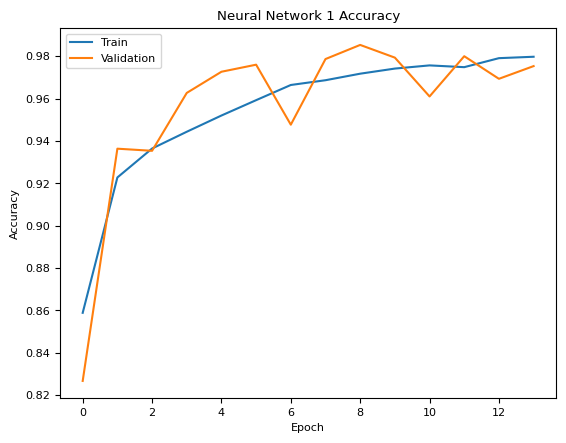

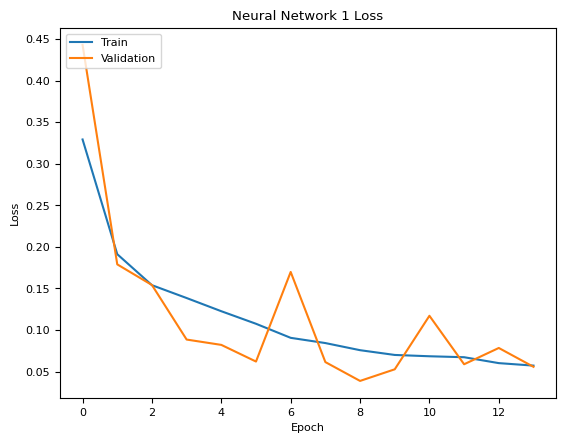

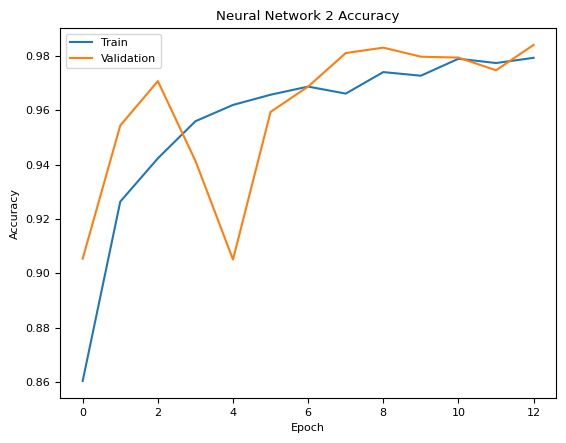

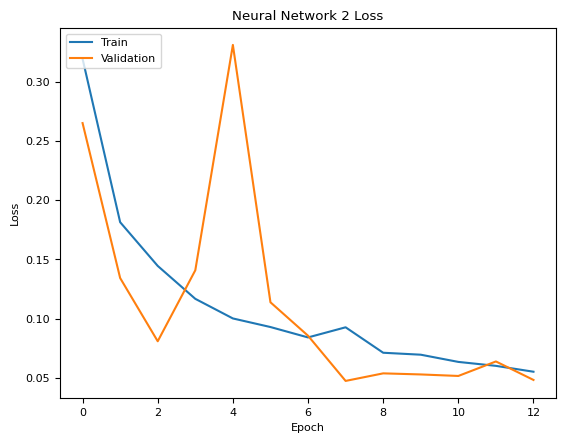

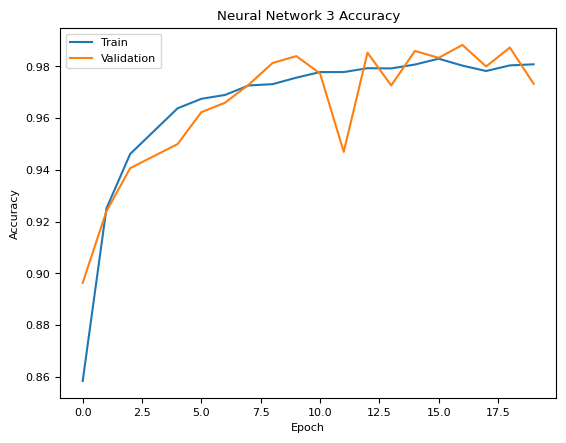

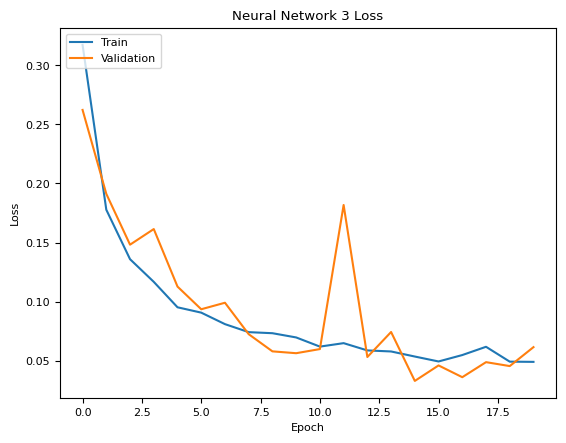

In [80]:
for i, h in enumerate(histories_rew):
  name = f"Neural Network {i+1}"
  plot_val_train(h, name)

###NN reweighted export

In [215]:
for i, model in enumerate(neural_models_rew):
  model.save(f'saved_NNs/neural_network_model_rew{i}')

###NN reweighted import

In [68]:
neural_models_rew = []

for i in range(0,3):
  model = load_model(f'saved_models/content/saved_NNs/neural_network_model_rew{i}')
  neural_models_rew.append(model)


###NN reweighted predict

In [71]:
neural_predictions_rew = []
for i, model in enumerate(neural_models_rew):
  name = f"Neural Network {i+1}"
  predict_nn(name, model, X_test, neural_predictions_rew)

Predicting with model Neural Network 1...
118/118 [==============================] - 1s 3ms/step
Predictions from model Neural Network 1 stored.


Predicting with model Neural Network 2...
118/118 [==============================] - 1s 4ms/step
Predictions from model Neural Network 2 stored.


Predicting with model Neural Network 3...
118/118 [==============================] - 1s 3ms/step
Predictions from model Neural Network 3 stored.




In [72]:
nn_metrics_rew = []

for i, y_pred in enumerate(neural_predictions_rew):
  name = f"Neural Network {i+1}"
  calc_nn_metrics(y_pred, y_test, nn_metrics_rew, name)
nn_metrics_rew = pd.DataFrame(nn_metrics_rew)
nn_metrics_rew

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Neural Network 1,0.947,0.948,0.947,0.947,0.947
1,Neural Network 2,0.944,0.966,0.920,0.943,0.944
2,Neural Network 3,0.962,0.971,0.951,0.961,0.962


###Performance

In [73]:
combined_metrics_rew = pd.concat([metrics_rew, nn_metrics_rew], ignore_index=True)
combined_metrics_rew

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Decision Tree,0.973,0.976,0.970,0.973,0.975
1,Gaussian Naive Bayes,0.822,0.780,0.895,0.834,0.889
2,Linear Perceptron,0.826,0.797,0.874,0.834,0.827
3,K Nearest Neighbor,0.883,0.836,0.952,0.890,0.883
4,AdaBoost,0.975,0.983,0.967,0.975,0.996
5,Random forest,0.986,0.987,0.984,0.986,0.999
6,Linear Regression,0.835,0.914,0.739,0.817,0.938
7,Neural Network 1,0.947,0.948,0.947,0.947,0.947
8,Neural Network 2,0.944,0.966,0.920,0.943,0.944
9,Neural Network 3,0.962,0.971,0.951,0.961,0.962


In [74]:
for i,model in enumerate(neural_models_rew):
  models_rew[f"Neural Network {i+1}"] = model

for i, prediction_list in enumerate(neural_predictions_rew):
  predictions_rew[f"Neural Network {i+1}"] = prediction_list.flatten()

##Bias detection after REWEIGHING

###Demographic Parity

In [75]:
index = list(models_rew.keys())
getFairnessTab(calculate_demographic_parity,
               models_rew,
               sensitive_features,
               predictions_rew,
               index,
               X_test,
               significance_level,
               tolerance,
               False)

,Sex_encoded,Age Range_encoded,European Residence_encoded,Protected Category_encoded
Decision Tree,male,< 20 years,non-european,yes
Gaussian Naive Bayes,male,< 20 years,non-european,yes
Linear Perceptron,male,< 20 years,non-european,yes
K Nearest Neighbor,male,< 20 years,non-european,yes
AdaBoost,male,< 20 years,non-european,yes
Random forest,male,< 20 years,non-european,yes
Linear Regression,male,< 20 years,non-european,yes
Neural Network 1,male,< 20 years,non-european,yes
Neural Network 2,male,< 20 years,non-european,yes
Neural Network 3,male,< 20 years,non-european,yes


### Equalized Odds

In [76]:
index = list(models_rew.keys())
getFairnessTab(calculate_equalized_odds,
               models_rew,
               sensitive_features,
               predictions_rew,
               index,
               X_test,
               significance_level,
               tolerance,
               False)

,Sex_encoded,Age Range_encoded,European Residence_encoded,Protected Category_encoded
Decision Tree,,,non-european,yes
Gaussian Naive Bayes,,,non-european,yes
Linear Perceptron,male,,,yes
K Nearest Neighbor,,,non-european,yes
AdaBoost,,,,yes
Random forest,,,non-european,yes
Linear Regression,,,,yes
Neural Network 1,,,,yes
Neural Network 2,,,,yes
Neural Network 3,,,,yes


##Adversarial Debiasing

In [152]:
epochs = 15
batch_size = 64
threshold = 0.5
logits = True

sensitive_f = [X_train[col] for col in sensitive_features]

In [153]:
def create_Main():
    model = Sequential([
        Dense(128, input_dim=X_train.shape[1], activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='relu'),
    ])

    return model

def create_adversary():
    adv = Sequential([
        Dense(128, input_dim=1, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='relu'),
    ])
    return adv

In [154]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Main
loss_fcn_main = BinaryCrossentropy(from_logits=logits)

# Adversary
loss_fcn_sex = BinaryCrossentropy(from_logits=logits)
loss_fcn_age = BinaryCrossentropy(from_logits=logits)
loss_fcn_res = BinaryCrossentropy(from_logits=logits)
loss_fcn_pro = BinaryCrossentropy(from_logits=logits)

loss_adv = [loss_fcn_sex, loss_fcn_age, loss_fcn_res, loss_fcn_pro]

# Optimizers
optimizerM = Adam(learning_rate=0.001)
optimizerS = Adam(learning_rate=0.0005)
optimizerA = Adam(learning_rate=0.0005)
optimizerR = Adam(learning_rate=0.0005)
optimizerPC = Adam(learning_rate=0.0005)



In [155]:
neural_models_adv = []

np.random.seed(85)
tf.random.set_seed(85)

model = create_Main()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
neural_models_adv.append(model)

In [145]:
neural_models_adv = []

for seed in range(85, 88):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = create_Main()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    neural_models_adv.append(model)

In [156]:
adversary_models = []

# Adversary for sex prediction
adversary_sex = create_adversary()
adversary_sex.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adversary_models.append(adversary_sex)

# Adversary for age prediction
adversary_age = create_adversary()
adversary_age.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adversary_models.append(adversary_age)

# Adversary for residence prediction
adversary_residence = create_adversary()
adversary_residence.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adversary_models.append(adversary_residence)

# Adversary for protected category prediction
adversary_protected = create_adversary()
adversary_protected.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adversary_models.append(adversary_protected)

In [157]:
def build_optimizers(neural_models, adversary_models):
    """Builds and returns a list of optimizers for the main and adversary models."""

    main_vars = [var for model in neural_models for var in model.trainable_variables]
    adv_vars = [var for model in adversary_models for var in model.trainable_variables]

    all_trainable_vars = main_vars + adv_vars

    # Rebuild optimizers with all variables after model creation
    optimizerM.build(all_trainable_vars)
    optimizerS.build(all_trainable_vars)
    optimizerA.build(all_trainable_vars)
    optimizerR.build(all_trainable_vars)
    optimizerPC.build(all_trainable_vars)

    optimizer_list = [optimizerS, optimizerA, optimizerR, optimizerPC]
    return optimizer_list

# Call build_optimizers after creating adversary models and main model
# ... (your code for creating adversary_models and neural_models_adv) ...
optimizer_list = build_optimizers(neural_models_adv, adversary_models)

In [158]:
def build_bacthed_data(X, y, sensitive_features, batch_size, names):

    Xb = []
    yb = []
    X_adv_b = []
    sens_f = []

    for i in range(0, len(X), batch_size):
        Xb.append(X[i:i+batch_size])
        yb.append(y[i:i+batch_size])

    for i in range(len(sensitive_features)):

        temp1 = []
        temp2 = []
        X_adv = X.drop(names[i], axis=1)
        sensitive_feature = sensitive_features[i]

        for j in range(0, len(X), batch_size):
            temp1.append(X_adv[j:j+batch_size])
            temp2.append(sensitive_feature[j:j+batch_size])

        X_adv_b.append(temp1)
        sens_f.append(temp2)

    return Xb, yb, sens_f, X_adv_b

Xb, yb, sens_f, X_adv_b = build_bacthed_data(X_train, y_train, sensitive_f, batch_size, sensitive_features)

In [159]:
def train_nn(main, adv, X, y, sens_f, X_adv, epochs, adv_n, print_step=10):

    for epoch in range(epochs):
        print()
        for i in range(len(X)):

            X_batch = tf.convert_to_tensor(X[i].values, dtype=tf.float32)
            y_batch = tf.convert_to_tensor(y[i].values, dtype=tf.float32)
            sens = tf.convert_to_tensor(sens_f[adv_n][i], dtype=tf.float32)

            with tf.GradientTape(persistent=True) as tape:

                # Main loss
                main_preds = main(X_batch, training=True)
                loss_main = loss_fcn_main(y_batch, main_preds)

                # Adversary loss
                adv_preds = adv[adv_n](main_preds, training=True)
                loss_adversary = loss_adv[adv_n](sens, adv_preds)

                # Combined loss
                combined_loss = tf.subtract(loss_main, tf.multiply(0.25, loss_adversary))


            # Update main weights
            gradients_main = tape.gradient(combined_loss, main.trainable_variables)
            filtered_gradients_main_and_vars = [(grad, var) for grad, var in zip(gradients_main, main.trainable_variables) if grad is not None]
            filtered_gradients_main, filtered_vars_main = zip(*filtered_gradients_main_and_vars)
            optimizerM.apply_gradients(zip(filtered_gradients_main, filtered_vars_main))

            # Update adversary weights
            model = adv[adv_n]

            optimizer = optimizer_list[adv_n]
            gradients_adv = tape.gradient(loss_adversary, model.trainable_variables)
            filtered_gradients_adv_and_vars = [(grad, var) for grad, var in zip(gradients_adv, model.trainable_variables) if grad is not None]
            filtered_gradients_adv, filtered_vars_adv = zip(*filtered_gradients_adv_and_vars)
            optimizer.apply_gradients(zip(filtered_gradients_adv, filtered_vars_adv))

            del tape

            if i % print_step == 0:
                print(f"Epoch {epoch+1} Batch {i}/{len(X)}:")
                print(f"  Main Loss: {loss_main.numpy()}, Adversary Loss: {loss_adversary}, Combined Loss: {combined_loss.numpy()}")

In [160]:
#UTILIZZA SOLO IL PRIMO AVVERSARIO

weight_sex = adversary_models[0].get_weights()
weight_age = adversary_models[1].get_weights()
weight_res = adversary_models[2].get_weights()
weight_pro = adversary_models[3].get_weights()

for i,model in enumerate(neural_models_adv):
  print()
  print("==================")
  print(f"Neural Network {i}")
  train_nn(model, adversary_models, Xb, yb, sens_f, X_adv_b, epochs, adv_n=0, print_step=60)

  adversary_models[0].set_weights(weight_sex)
  adversary_models[1].set_weights(weight_age)
  adversary_models[2].set_weights(weight_res)
  adversary_models[3].set_weights(weight_pro)


Neural Network 0

Epoch 1 Batch 0/235:
  Main Loss: 0.9368442893028259, Adversary Loss: 0.6401183605194092, Combined Loss: 0.7768146991729736
Epoch 1 Batch 60/235:
  Main Loss: 0.6424757242202759, Adversary Loss: 0.6344121098518372, Combined Loss: 0.4838727116584778
Epoch 1 Batch 120/235:
  Main Loss: 0.5912994742393494, Adversary Loss: 0.5404961109161377, Combined Loss: 0.45617544651031494
Epoch 1 Batch 180/235:
  Main Loss: 0.4459465742111206, Adversary Loss: 0.6646922826766968, Combined Loss: 0.2797735035419464

Epoch 2 Batch 0/235:
  Main Loss: 0.505397379398346, Adversary Loss: 0.6114972233772278, Combined Loss: 0.3525230884552002
Epoch 2 Batch 60/235:
  Main Loss: 0.46968087553977966, Adversary Loss: 0.6083155870437622, Combined Loss: 0.3176019787788391
Epoch 2 Batch 120/235:
  Main Loss: 0.5432260036468506, Adversary Loss: 0.56458979845047, Combined Loss: 0.4020785689353943
Epoch 2 Batch 180/235:
  Main Loss: 0.4075479209423065, Adversary Loss: 0.6574940085411072, Combined Loss

In [214]:
for i, model in enumerate(neural_models_adv):
  model.save(f'saved_NNs/neural_network_model_adv{i}')

In [78]:
neural_models_adv = []
n=1

for i in range(0,n):
  model = load_model(f'saved_models/content/saved_NNs/neural_network_model_adv{i}')
  neural_models_adv.append(model)


In [101]:
main_predictions = []

for model in neural_models_adv:
    y_pred = (model.predict(X_test) > 0.5).astype("int32").squeeze()
    main_predictions.append(y_pred)

118/118 [==============================] - 1s 5ms/step


In [102]:
nn_metrics_adv = []

for i, y_pred in enumerate(main_predictions):
    name = f"Neural Network {i+1}"
    calc_nn_metrics(y_pred, y_test, nn_metrics_adv, name)

# Display the 7 models performances
nn_metrics_adv = pd.DataFrame(nn_metrics_adv)
nn_metrics_adv

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Neural Network 1,0.921,0.996,0.846,0.915,0.921


###Demographic Parity

In [108]:
models_adv = {}
predictions_adv = {}
for i,model in enumerate(neural_models_adv):
  models_adv[f"Neural Network {i+1}"] = model

for i, prediction_list in enumerate(main_predictions):
  predictions_adv[f"Neural Network {i+1}"] = prediction_list.flatten()

In [110]:
index = [f"Neural Network {i+1}" for i in range(len(neural_models_adv))]
getFairnessTab(calculate_demographic_parity,
               models_adv,
               sensitive_features,
               predictions_adv,
               index,
               X_test,
               significance_level,
               tolerance,
               False)

,Sex_encoded,Age Range_encoded,European Residence_encoded,Protected Category_encoded
Neural Network 1,male,< 20 years,non-european,yes


### Equalized Odds

In [112]:
index = [f"Neural Network {i+1}" for i in range(len(neural_models_adv))]
getFairnessTab(calculate_equalized_odds,
               models_adv,
               sensitive_features,
               predictions_adv,
               index,
               X_test,
               significance_level,
               tolerance,
               False)

,Sex_encoded,Age Range_encoded,European Residence_encoded,Protected Category_encoded
Neural Network 1,,,non-european,yes


##Adversarial with reweighted

In [170]:

# Main
loss_fcn_main_rew = BinaryCrossentropy(from_logits=logits)

# Adversary
loss_fcn_sex_rew = BinaryCrossentropy(from_logits=logits)
loss_fcn_age_rew = BinaryCrossentropy(from_logits=logits)
loss_fcn_res_rew = BinaryCrossentropy(from_logits=logits)
loss_fcn_pro_rew = BinaryCrossentropy(from_logits=logits)

loss_adv_rew = [loss_fcn_sex_rew, loss_fcn_age_rew, loss_fcn_res_rew, loss_fcn_pro_rew]

# Optimizers
optimizerM_rew = Adam(learning_rate=0.001)
optimizerS_rew = Adam(learning_rate=0.0005)
optimizerA_rew = Adam(learning_rate=0.0005)
optimizerR_rew = Adam(learning_rate=0.0005)
optimizerPC_rew = Adam(learning_rate=0.0005)



In [171]:
neural_models_adv_rew = []

np.random.seed(85)
tf.random.set_seed(85)

model = create_Main()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
neural_models_adv_rew.append(model)

In [172]:
adversary_models_rew = []

# Adversary for sex prediction
adversary_sex = create_adversary()
adversary_sex.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adversary_models_rew.append(adversary_sex)

# Adversary for age prediction
adversary_age = create_adversary()
adversary_age.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adversary_models_rew.append(adversary_age)

# Adversary for residence prediction
adversary_residence = create_adversary()
adversary_residence.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adversary_models_rew.append(adversary_residence)

# Adversary for protected category prediction
adversary_protected = create_adversary()
adversary_protected.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adversary_models_rew.append(adversary_protected)

In [173]:
optimizer_list = build_optimizers(neural_models_adv_rew, adversary_models_rew)

In [174]:
Xb, yb, sens_f, X_adv_b = build_bacthed_data(X_train_reweighted, y_train_reweighted, sensitive_f, batch_size, sensitive_features)

In [175]:
#UTILIZZA SOLO IL PRIMO AVVERSARIO

weight_sex = adversary_models_rew[0].get_weights()
weight_age = adversary_models_rew[1].get_weights()
weight_res = adversary_models_rew[2].get_weights()
weight_pro = adversary_models_rew[3].get_weights()

for i,model in enumerate(neural_models_adv_rew):
  print()
  print("==================")
  print(f"Neural Network {i}")
  train_nn(model, adversary_models_rew, Xb, yb, sens_f, X_adv_b, epochs, adv_n=0, print_step=60)

  adversary_models_rew[0].set_weights(weight_sex)
  adversary_models_rew[1].set_weights(weight_age)
  adversary_models_rew[2].set_weights(weight_res)
  adversary_models_rew[3].set_weights(weight_pro)


Neural Network 0

Epoch 1 Batch 0/235:
  Main Loss: 0.8583258390426636, Adversary Loss: 0.6567234396934509, Combined Loss: 0.6941449642181396
Epoch 1 Batch 60/235:
  Main Loss: 0.6753201484680176, Adversary Loss: 0.6475679874420166, Combined Loss: 0.5134281516075134
Epoch 1 Batch 120/235:
  Main Loss: 0.6175087690353394, Adversary Loss: 0.6125246286392212, Combined Loss: 0.46437761187553406
Epoch 1 Batch 180/235:
  Main Loss: 0.732619047164917, Adversary Loss: 0.6586639881134033, Combined Loss: 0.5679530501365662

Epoch 2 Batch 0/235:
  Main Loss: 0.6233323812484741, Adversary Loss: 0.6428521871566772, Combined Loss: 0.4626193344593048
Epoch 2 Batch 60/235:
  Main Loss: 0.6176988482475281, Adversary Loss: 0.630415678024292, Combined Loss: 0.4600949287414551
Epoch 2 Batch 120/235:
  Main Loss: 0.5765361785888672, Adversary Loss: 0.6030896902084351, Combined Loss: 0.4257637560367584
Epoch 2 Batch 180/235:
  Main Loss: 0.7202948331832886, Adversary Loss: 0.681287407875061, Combined Loss:

In [213]:
for i, model in enumerate(neural_models_adv_rew):
  model.save(f'saved_NNs/neural_network_model_adv_rew{i}')

In [114]:
neural_models_adv_rew = []
n=1
for i in range(0,n):
  model = load_model(f'saved_models/content/saved_NNs/neural_network_model_adv_rew{i}')
  neural_models_adv_rew.append(model)


In [115]:
main_predictions_rew = []
for model in neural_models_adv_rew:
    y_pred = (model.predict(X_test) > 0.5).astype("int32").squeeze()
    main_predictions_rew.append(y_pred)

118/118 [==============================] - 0s 2ms/step


In [116]:
nn_metrics_adv_rew = []

for i, y_pred in enumerate(main_predictions_rew):
    name = f"Neural Network {i+1}"
    calc_nn_metrics(y_pred, y_test, nn_metrics_adv_rew, name)

# Display the 7 models performances
nn_metrics_adv_rew = pd.DataFrame(nn_metrics_adv_rew)
nn_metrics_adv_rew

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Neural Network 1,0.903,0.995,0.81,0.893,0.903


###Demographic Parity

In [117]:
models_adv_rew = {}
predictions_adv_rew = {}
for i,model in enumerate(neural_models_adv_rew):
  models_adv_rew[f"Neural Network {i+1}"] = model

for i, prediction_list in enumerate(main_predictions_rew):
  predictions_adv_rew[f"Neural Network {i+1}"] = prediction_list.flatten()

In [118]:
index = [f"Neural Network {i+1}" for i in range(len(neural_models_adv))]
getFairnessTab(calculate_demographic_parity,
               models_adv_rew,
               sensitive_features,
               predictions_adv_rew,
               index,
               X_test,
               significance_level,
               tolerance,
               False)

,Sex_encoded,Age Range_encoded,European Residence_encoded,Protected Category_encoded
Neural Network 1,male,< 20 years,non-european,yes


### Equalized Odds

In [119]:
index = [f"Neural Network {i+1}" for i in range(len(neural_models_adv))]
getFairnessTab(calculate_equalized_odds,
               models_adv_rew,
               sensitive_features,
               predictions_adv_rew,
               index,
               X_test,
               significance_level,
               tolerance,
               False)

,Sex_encoded,Age Range_encoded,European Residence_encoded,Protected Category_encoded
Neural Network 1,,,,yes


### Export folder with NNs

In [217]:
!zip -r all_models.zip /content/saved_NNs

  adding: content/saved_NNs/ (stored 0%)
  adding: content/saved_NNs/neural_network_model_adv_rew0/ (stored 0%)
  adding: content/saved_NNs/neural_network_model_adv_rew0/saved_model.pb (deflated 90%)
  adding: content/saved_NNs/neural_network_model_adv_rew0/fingerprint.pb (stored 0%)
  adding: content/saved_NNs/neural_network_model_adv_rew0/assets/ (stored 0%)
  adding: content/saved_NNs/neural_network_model_adv_rew0/variables/ (stored 0%)
  adding: content/saved_NNs/neural_network_model_adv_rew0/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/saved_NNs/neural_network_model_adv_rew0/variables/variables.index (deflated 65%)
  adding: content/saved_NNs/neural_network_model_adv_rew0/keras_metadata.pb (deflated 92%)
  adding: content/saved_NNs/neural_network_model0/ (stored 0%)
  adding: content/saved_NNs/neural_network_model0/saved_model.pb (deflated 89%)
  adding: content/saved_NNs/neural_network_model0/fingerprint.pb (stored 0%)
  adding: content/saved_NNs/neura

In [219]:
!cp all_models.zip $drive_dir